# Overlaying speed traces of two laps

Compare two fastest laps by overlaying their speed traces.


In [22]:
%pip install fastf1
%pip install seaborn
%matplotlib inline


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [69]:
import matplotlib.pyplot as plt

import fastf1.plotting

import pandas as pd

from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

import seaborn as sns

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

from matplotlib import gridspec

from matplotlib.collections import LineCollection

import os

In [116]:


# enable some matplotlib patches for plotting timedelta values and load
# FastF1's default color scheme
fastf1.plotting.setup_mpl(misc_mpl_mods=False)

# load a session and its telemetry data
grand_prix_session = 'R'
grand_prix_year = 2024
grand_prix_weekend = 3
session = fastf1.get_session(grand_prix_year, grand_prix_weekend, grand_prix_session)
grand_prix_name = session.event['EventName']
grand_prix_name_official = session.event['OfficialEventName']
session.load()

core           INFO 	Loading data for Australian Grand Prix - Race [v3.3.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api          

First, we select the two laps that we want to compare



In [113]:
ver_lap = session.laps.pick_driver('VER').pick_fastest()
per_lap = session.laps.pick_driver('PER').pick_fastest()
sai_lap = session.laps.pick_driver('SAI').pick_fastest()
lec_lap = session.laps.pick_driver('LEC').pick_fastest()
#bea_lap = session.laps.pick_driver('BEA').pick_fastest()
alo_lap = session.laps.pick_driver('ALO').pick_fastest()
str_lap = session.laps.pick_driver('STR').pick_fastest()
ham_lap = session.laps.pick_driver('HAM').pick_fastest()
rus_lap = session.laps.pick_driver('RUS').pick_fastest()

Next we get the telemetry data for each lap. We also add a 'Distance' column
to the telemetry dataframe as this makes it easier to compare the laps.



In [114]:
ver_tel = ver_lap.get_car_data().add_distance()
per_tel = per_lap.get_car_data().add_distance()
sai_tel = sai_lap.get_car_data().add_distance()
lec_tel = lec_lap.get_car_data().add_distance()
#bea_tel = bea_lap.get_car_data().add_distance()
alo_tel = alo_lap.get_car_data().add_distance()
str_tel = str_lap.get_car_data().add_distance()
ham_tel = ham_lap.get_car_data().add_distance()
rus_tel = rus_lap.get_car_data().add_distance()

In [87]:
def name_to_color_hex(name):
    """Convierte un nombre en un color hexadecimal."""
    
    # Diccionario de colores predefinidos para ciertos pilotos
    default_colors = {
        'ALO': '#009F60',  # Verde Aston Martin para Alonso.
        'STR': '#007F50',  # Un verde ligeramente diferente para Stroll, pero aún en la gama de Aston Martin.
        'HAM': '#00D2BE',  # Turquesa, ya definido para Mercedes.
        'RUS': '#5E5E5E',  # Gris, para diferenciarlo de Hamilton pero aún asociado con Mercedes.
        'VER': '#0600EF',  # Azul, ya definido.
        'PER': '#f400FF',  # Un azul diferente a Verstappen, pero cercano para reflejar Red Bull Racing.
        'SAI': '#DC0000',  # Rojo, colores de Ferrari.
        'LEC': '#FFD700',  # Amarillo para Leclerc, como pediste.
        'BEA': '#F596C8',  # Rosa, imaginando un color distintivo que no choque con otros.
        'RIC': '#FF8700',  # Naranja, asociado con McLaren.
        'TSU': '#2B4562',  # Azul oscuro, pensando en AlphaTauri.
        'PIA': '#FFA500',  # Un naranja diferente para Piastri, compañero de equipo en McLaren.
        'LAN': '#FF5733'  # Ya definido, pero ahora representa McLaren junto con Piastri.
    }
    
    # Verifica si el nombre está en el diccionario de colores predefinidos
    if name in default_colors:
        return default_colors[name]
    else:
        # Si no está predefinido, genera un color nuevo
        hash_value = abs(hash(name))
        color_hex = f'#{hash_value:06X}'[-6:]
        color_hex_full = f"#{color_hex}"
        return color_hex_full

In [28]:
def format_lap_time(timedelta):
    """
    Formatea un objeto Timedelta a una cadena en el formato MM:SS.sss.
    
    :param timedelta: Timedelta, el tiempo de vuelta a formatear.
    :return: str, el tiempo formateado como MM:SS.sss.
    """
    total_seconds = timedelta.total_seconds()
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    formatted_time = f"{minutes:02d}:{seconds:06.3f}"
    return formatted_time

In [ ]:
def format_lap_time_full(timedelta):
    """
    Formatea un objeto Timedelta a una cadena en el formato MM:SS.sss.
    
    :param timedelta: Timedelta, el tiempo de vuelta a formatear.
    :return: str, el tiempo formateado como MM:SS.sss.
    """
    total_seconds = timedelta.total_seconds()
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    formatted_time = f"{minutes:02d}:{seconds:06.3f}"
    return formatted_time

In [29]:
def calculate_sector_time_diff(telemetry, driver1, driver2):
    sector_time_diff = telemetry.loc[telemetry['Driver'] == driver1, 'Sector_time'] - \
                       telemetry.loc[telemetry['Driver'] == driver2, 'Sector_time']
    return sector_time_diff

Finally, we create a plot and plot both speed traces.
We color the individual lines with the driver's team colors.



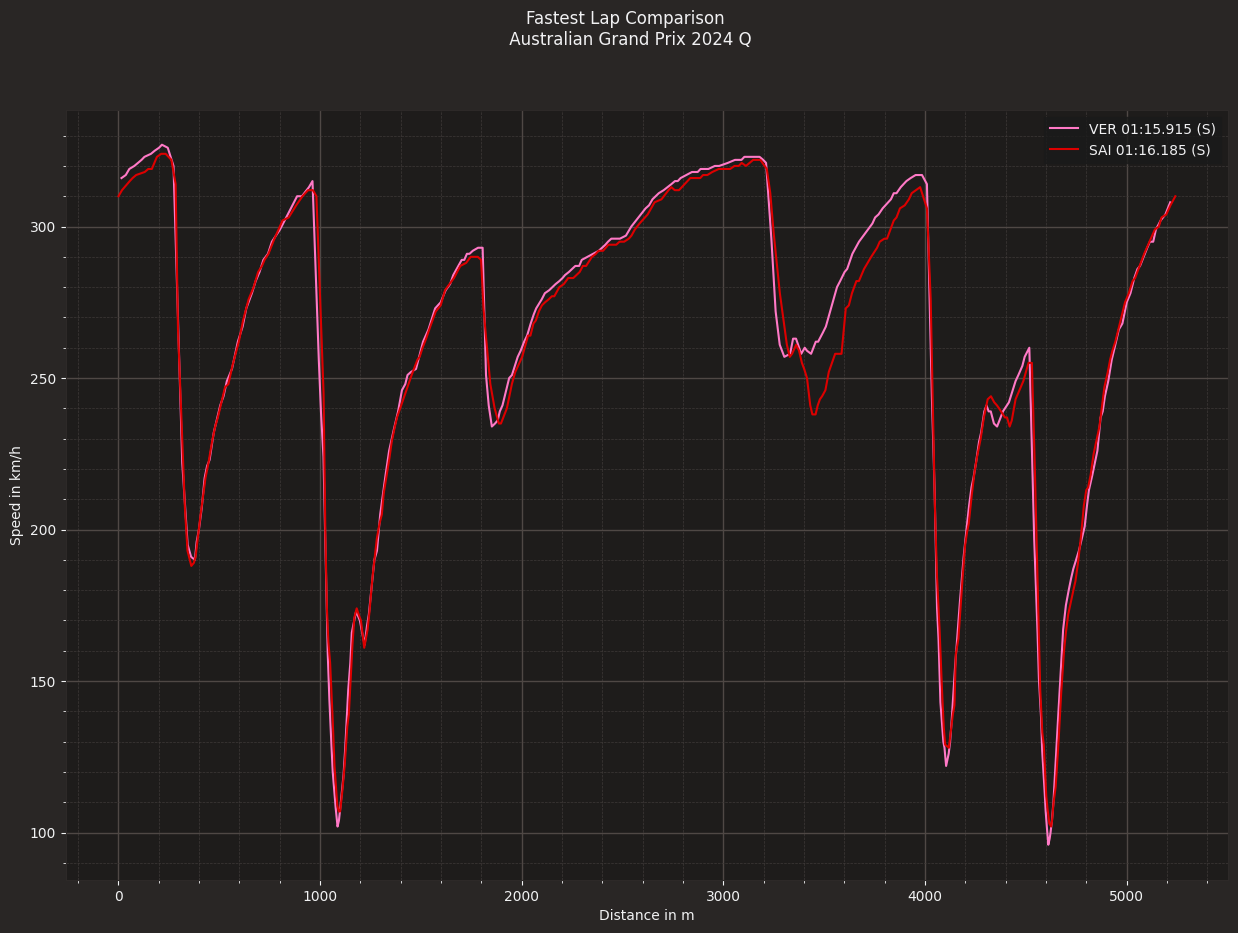

In [115]:
rbr_color = fastf1.plotting.team_color('RBR')
mer_color = fastf1.plotting.team_color('MER')
ast_color = fastf1.plotting.team_color('AST')
fer_color = fastf1.plotting.team_color('FER')
mcl_color = fastf1.plotting.team_color('MCL')

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(ver_tel['Distance'], ver_tel['Speed'], label=f"VER {format_lap_time(ver_lap['LapTime'])} ({ver_lap['Compound'][0]})")
#ax.plot(per_tel['Distance'], per_tel['Speed'], label=f"PER {format_lap_time(per_lap['LapTime'])} ({per_lap['Compound'][0]})")
#ax.plot(ver_tel['Distance'], lec_tel['Speed'], label=f"LEC {format_lap_time(lec_lap['LapTime'])} ({lec_lap['Compound'][0]})")
#ax.plot(per_tel['Distance'], bea_tel['Speed'], label=f"BEA {format_lap_time(bea_lap['LapTime'])} ({bea_lap['Compound'][0]})")
ax.plot(sai_tel['Distance'], sai_tel['Speed'], color=fer_color, label=f"SAI {format_lap_time(sai_lap['LapTime'])} ({sai_lap['Compound'][0]})")
#ax.plot(alo_tel['Distance'], alo_tel['Speed'], color=ast_color, label=f"ALO {format_lap_time(alo_lap['LapTime'])} ({alo_lap['Compound'][0]})")
#ax.plot(str_tel['Distance'], str_tel['Speed'], label=f"STR {format_lap_time(str_lap['LapTime'])} ({str_lap['Compound'][0]})")
#ax.plot(ham_tel['Distance'], ham_tel['Speed'], color=mer_color, label=f"HAM {format_lap_time(ham_lap['LapTime'])} ({ham_lap['Compound'][0]})")
#ax.plot(rus_tel['Distance'], rus_tel['Speed'], color=mer_color, label=f"RUS {format_lap_time(rus_lap['LapTime'])} ({rus_lap['Compound'][0]})")

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{grand_prix_name} {session.event.year} {grand_prix_session}")

plt.show()

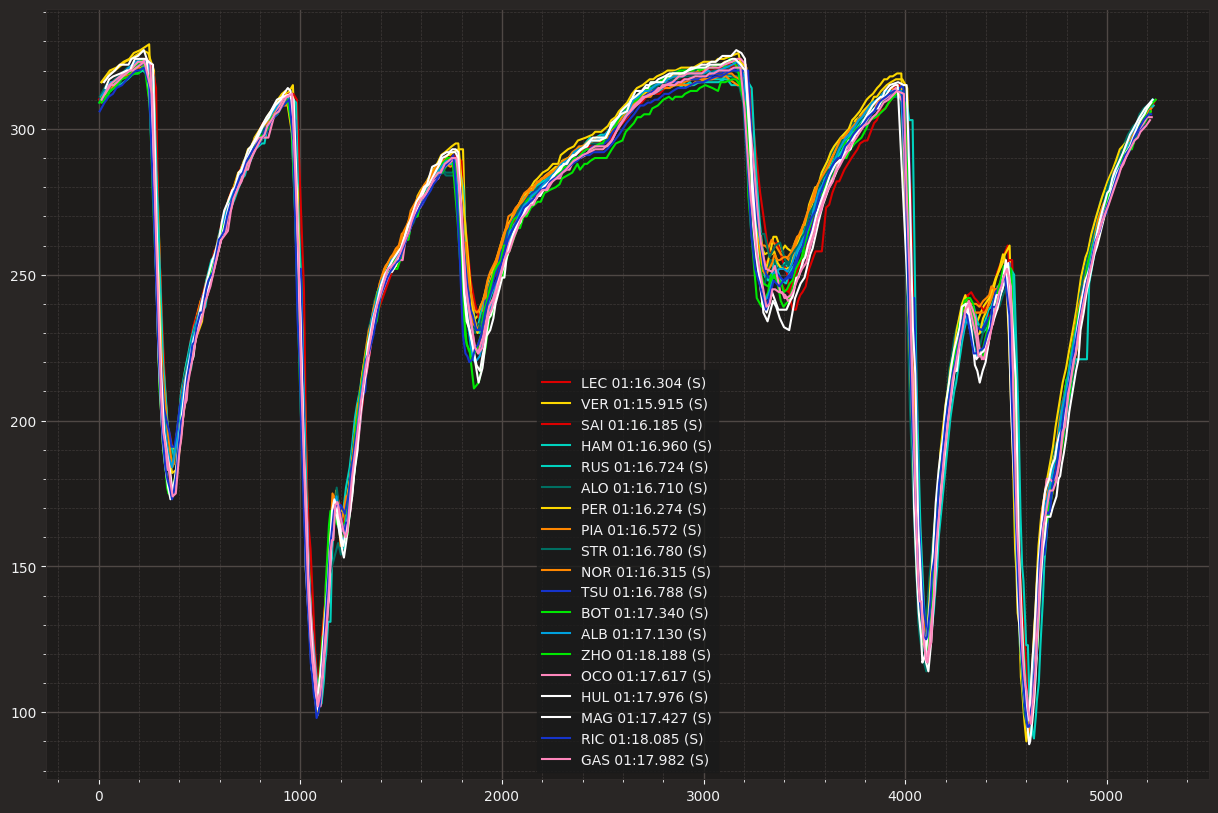

In [31]:
# Obtén una lista única de corredores desde la sesión
corredores = session.laps['Driver'].unique()

# Prepara la figura de matplotlib
#fig, ax = plt.subplots()
# Prepara la figura de matplotlib con un tamaño mayor
fig, ax = plt.subplots(figsize=(15, 10))  # Ajusta estos valores para cambiar el tamaño


# Itera sobre cada corredor para obtener su vuelta más rápida y graficarla
for corredor in corredores:
    # Selecciona la vuelta más rápida
    vuelta_rapida = session.laps.pick_driver(corredor).pick_fastest()
    
    # Extrae los datos del coche y agrega la distancia
    datos_coche = vuelta_rapida.get_car_data().add_distance()
    
    # Determina el equipo del corredor (si la información está disponible)
    equipo = vuelta_rapida['Team']
    
    # Obtiene el color asociado al equipo del corredor
    color_equipo = fastf1.plotting.team_color(equipo)
    
    # Formatea el tiempo de vuelta para la etiqueta
    tiempo_vuelta = format_lap_time(vuelta_rapida['LapTime'])
    
    # Añade la traza al gráfico
    ax.plot(datos_coche['Distance'], datos_coche['Speed'], color=color_equipo, 
            label=f"{corredor} {tiempo_vuelta} ({vuelta_rapida['Compound'][0]})")

# Ajusta detalles finales del gráfico
ax.legend()
plt.show()

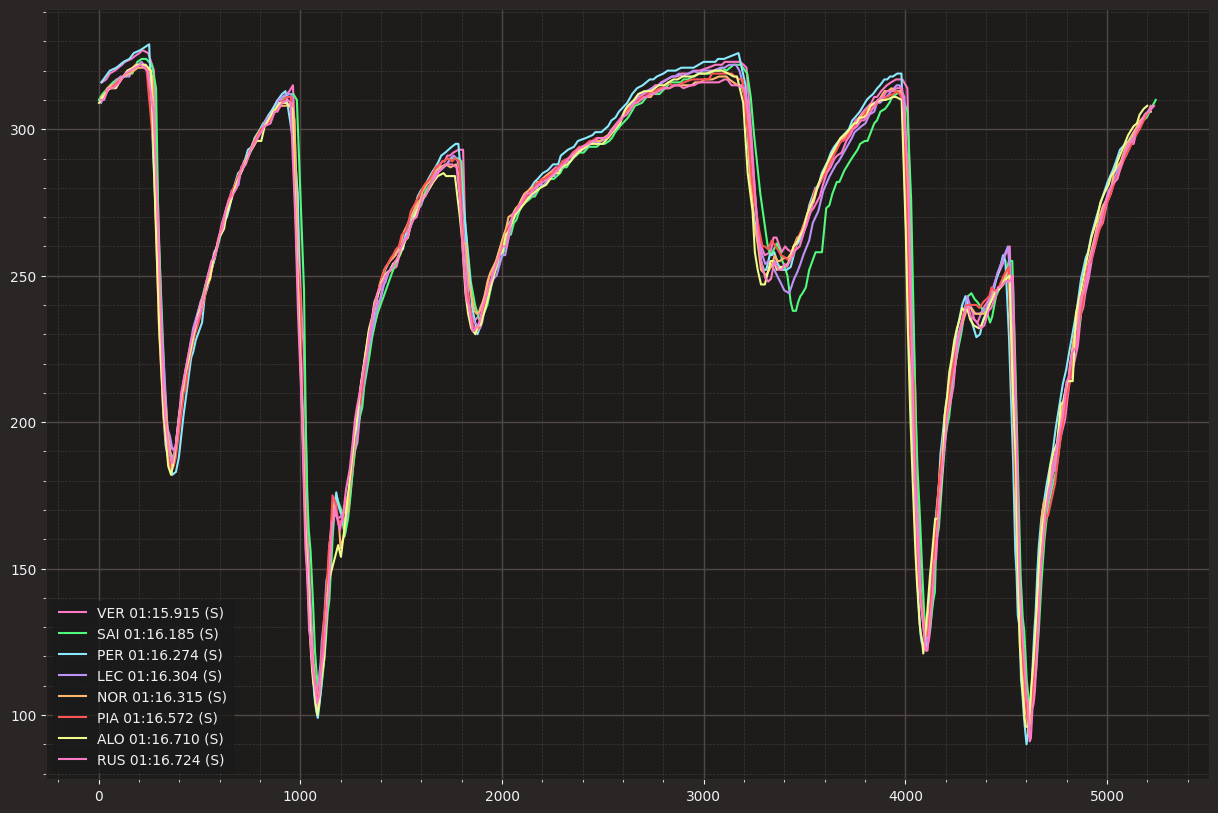

In [32]:

fastf1.plotting.setup_mpl()

# Asumiendo que 'session' ya contiene los datos de la sesión de interés cargados
# Obtén todas las vueltas más rápidas de todos los corredores
vueltas_rapidas = [session.laps.pick_driver(corredor).pick_fastest() for corredor in session.laps['Driver'].unique()]

# Filtra las vueltas para asegurar que todas tienen un tiempo registrado
vueltas_rapidas = [vuelta for vuelta in vueltas_rapidas if vuelta['LapTime'] is not None]

# Ordena las vueltas por tiempo de vuelta
vueltas_rapidas.sort(key=lambda x: x['LapTime'])

# Selecciona las 10 vueltas más rápidas
diez_vueltas_mas_rapidas = vueltas_rapidas[:8]

# Prepara la figura de matplotlib con un tamaño mayor
fig, ax = plt.subplots(figsize=(15, 10))

# Grafica cada una de las 10 vueltas más rápidas
for vuelta in diez_vueltas_mas_rapidas:
    datos_coche = vuelta.get_car_data().add_distance()
    equipo = vuelta['Team']
    color_equipo = fastf1.plotting.team_color(equipo)
    corredor = vuelta['Driver']
    #tiempo_vuelta = vuelta['LapTime'].total_seconds()  # Modifica aquí según cómo desees formatear el tiempo
    tiempo_vuelta = format_lap_time(vuelta['LapTime'])
    
    ax.plot(datos_coche['Distance'], datos_coche['Speed'], 
            label=f"{corredor} {tiempo_vuelta} ({vuelta_rapida['Compound'][0]})")

# Añade leyendas y ajustes finales al gráfico
ax.legend()
plt.show()

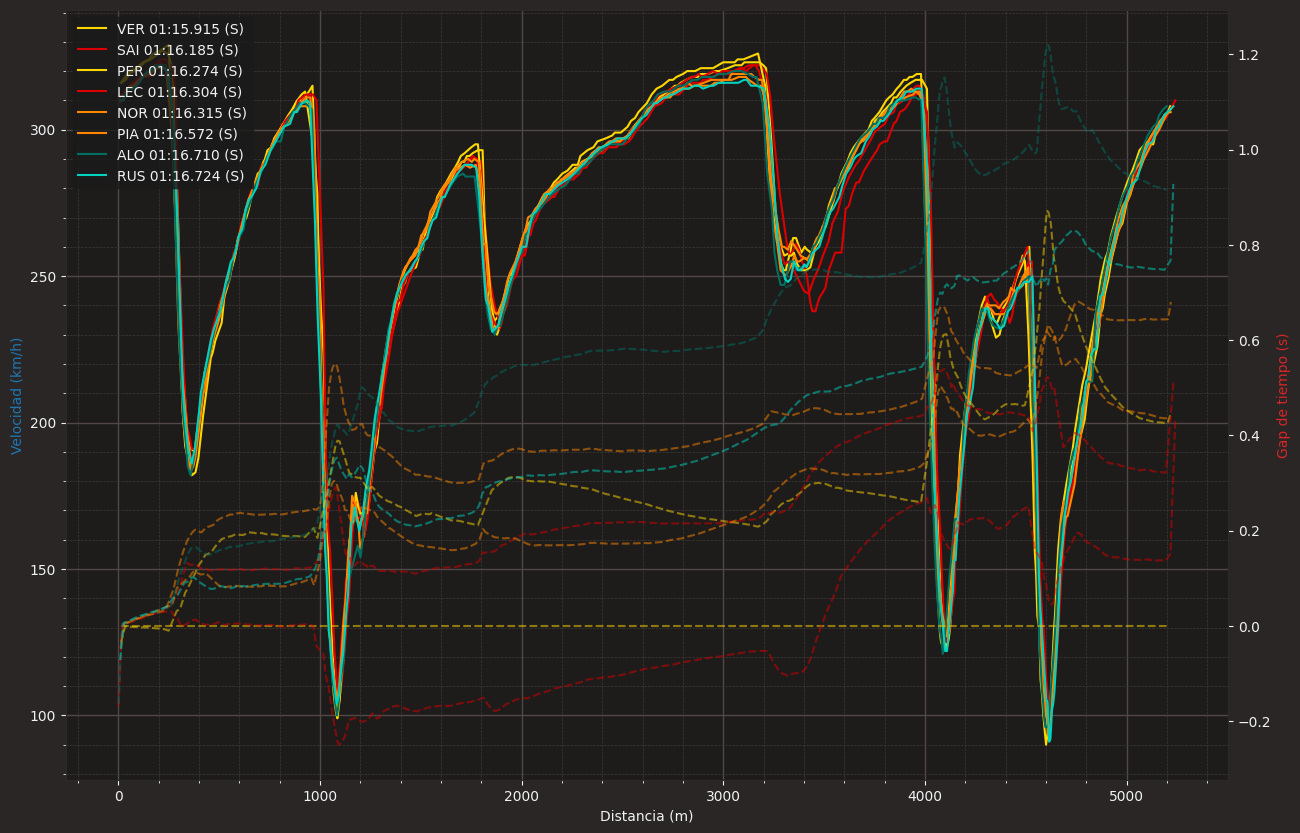

In [33]:
fastf1.plotting.setup_mpl()

# Preparación inicial igual...
vueltas_rapidas = [session.laps.pick_driver(corredor).pick_fastest() for corredor in session.laps['Driver'].unique()]
vueltas_rapidas = [vuelta for vuelta in vueltas_rapidas if vuelta['LapTime'] is not None]
vueltas_rapidas.sort(key=lambda x: x['LapTime'])
diez_vueltas_mas_rapidas = vueltas_rapidas[:8]

# Vuelta de referencia (la mejor vuelta)
vuelta_referencia = vueltas_rapidas[0]
datos_coche_ref = vuelta_referencia.get_car_data().add_distance()
tiempo_ref = datos_coche_ref['Time'].dt.total_seconds()

fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()  # Segundo eje para el gap de tiempo

for vuelta in diez_vueltas_mas_rapidas:
    datos_coche = vuelta.get_car_data().add_distance()
    equipo = vuelta['Team']
    color_equipo = fastf1.plotting.team_color(equipo)
    corredor = vuelta['Driver']
    tiempo_vuelta = format_lap_time(vuelta['LapTime'])

    # Graficar la velocidad en el primer eje
    ax1.plot(datos_coche['Distance'], datos_coche['Speed'], label=f"{corredor} {tiempo_vuelta} ({vuelta['Compound'][0]})", color=color_equipo)

    # Calcular y graficar el gap de tiempo en el segundo eje
    tiempo_vuelta_sec = datos_coche['Time'].dt.total_seconds()
    distancia = datos_coche['Distance']
    tiempo_ref_interp = np.interp(distancia, datos_coche_ref['Distance'], tiempo_ref)
    gap_tiempo = tiempo_vuelta_sec - tiempo_ref_interp
    
    # Para evitar superposición de etiquetas, podemos no añadir una leyenda aquí, o usar un esquema de color/nombres diferenciado
    ax2.plot(distancia, gap_tiempo, linestyle='--', color=color_equipo, alpha=0.5)  # alpha para diferenciar la línea de gap

# Configuración de los ejes
ax1.set_xlabel('Distancia (m)')
ax1.set_ylabel('Velocidad (km/h)', color='tab:blue')
ax2.set_ylabel('Gap de tiempo (s)', color='tab:red')
ax1.legend(loc='upper left')

plt.show()

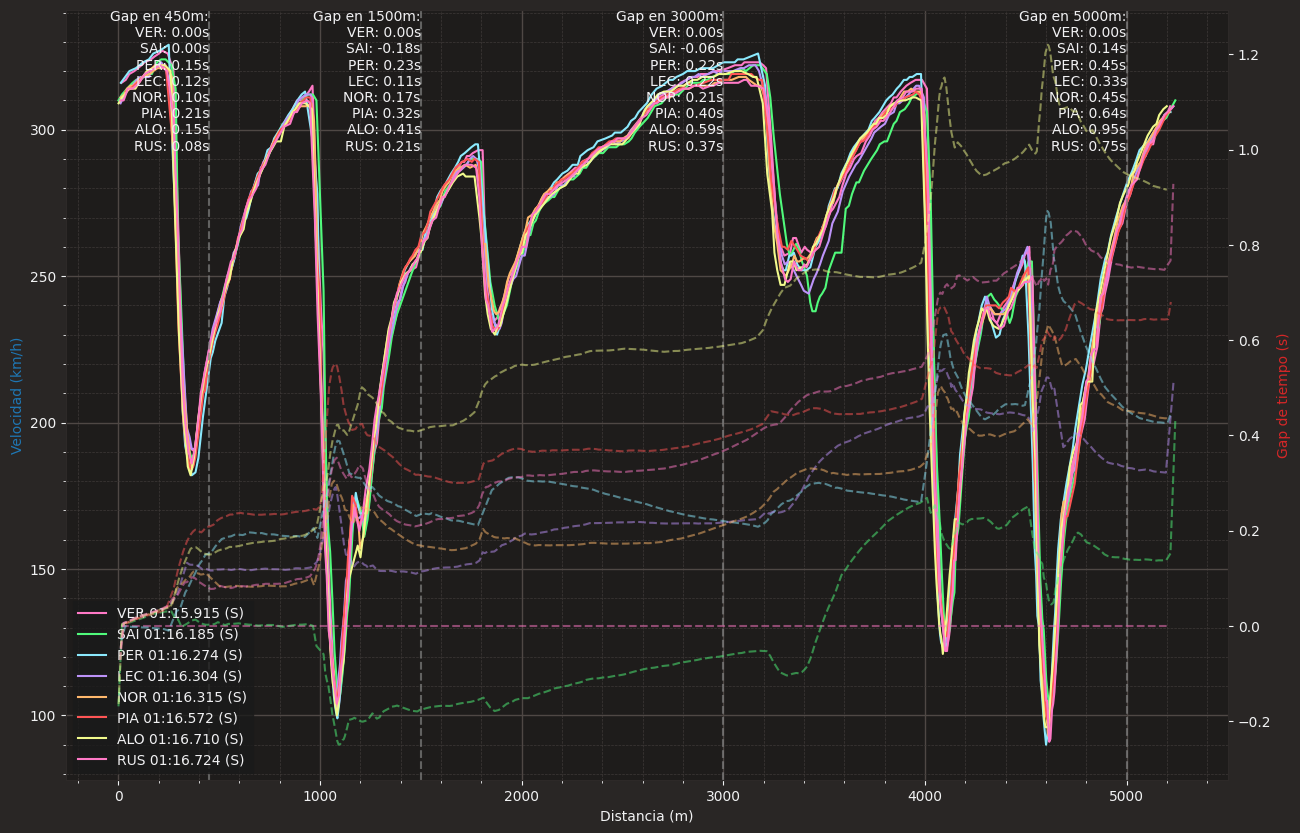

In [34]:
fastf1.plotting.setup_mpl()

# Preparación inicial igual...
vueltas_rapidas = [session.laps.pick_driver(corredor).pick_fastest() for corredor in session.laps['Driver'].unique()]
vueltas_rapidas = [vuelta for vuelta in vueltas_rapidas if vuelta['LapTime'] is not None]
vueltas_rapidas.sort(key=lambda x: x['LapTime'])
diez_vueltas_mas_rapidas = vueltas_rapidas[:8]

# Vuelta de referencia (la mejor vuelta)
vuelta_referencia = vueltas_rapidas[0]
datos_coche_ref = vuelta_referencia.get_car_data().add_distance()
tiempo_ref = datos_coche_ref['Time'].dt.total_seconds()

fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()  # Segundo eje para el gap de tiempo

# Distancias específicas para mostrar el gap de tiempo
distancias_puntos = [450, 1500, 3000, 5000]

# Inicializar diccionario para almacenar los gaps en puntos específicos
gaps_en_puntos = {distancia: [] for distancia in distancias_puntos}

for vuelta in diez_vueltas_mas_rapidas:
    datos_coche = vuelta.get_car_data().add_distance()
    equipo = vuelta['Team']
    color_equipo = fastf1.plotting.team_color(equipo)
    corredor = vuelta['Driver']
    tiempo_vuelta = format_lap_time(vuelta['LapTime'])

    ax1.plot(datos_coche['Distance'], datos_coche['Speed'], label=f"{corredor} {tiempo_vuelta} ({vuelta['Compound'][0]})")

    # Cálculo de gap de tiempo
    tiempo_vuelta_sec = datos_coche['Time'].dt.total_seconds()
    distancia = datos_coche['Distance']
    tiempo_ref_interp = np.interp(distancia, datos_coche_ref['Distance'], tiempo_ref)
    gap_tiempo = tiempo_vuelta_sec - tiempo_ref_interp
    ax2.plot(distancia, gap_tiempo, linestyle='--', alpha=0.5)

    # Calcular y almacenar el gap de tiempo en puntos específicos de distancia
    for punto in distancias_puntos:
        gap_en_punto = np.interp(punto, distancia, gap_tiempo)
        gaps_en_puntos[punto].append((corredor, gap_en_punto))

# Añadir líneas verticales y anotaciones para los puntos específicos
for punto in distancias_puntos:
    # Línea vertical en cada punto específico
    ax1.axvline(x=punto, color='grey', linestyle='--', alpha=0.7)

    # Anotar los gaps de tiempo en los puntos específicos
    texto_anotacion = f"Gap en {punto}m:\n" + "\n".join([f"{corredor}: {gap:.2f}s" for corredor, gap in gaps_en_puntos[punto]])
    ax1.text(punto, ax1.get_ylim()[1], texto_anotacion, verticalalignment='top', horizontalalignment='right')

# Configuración de los ejes
ax1.set_xlabel('Distancia (m)')
ax1.set_ylabel('Velocidad (km/h)', color='tab:blue')
ax2.set_ylabel('Gap de tiempo (s)', color='tab:red')
ax1.legend()

plt.show()

In [35]:
#####

MUESTRA GRAFICA

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105d71f70>>
Traceback (most recent call last):
  File "/Users/enrique.mendoza/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


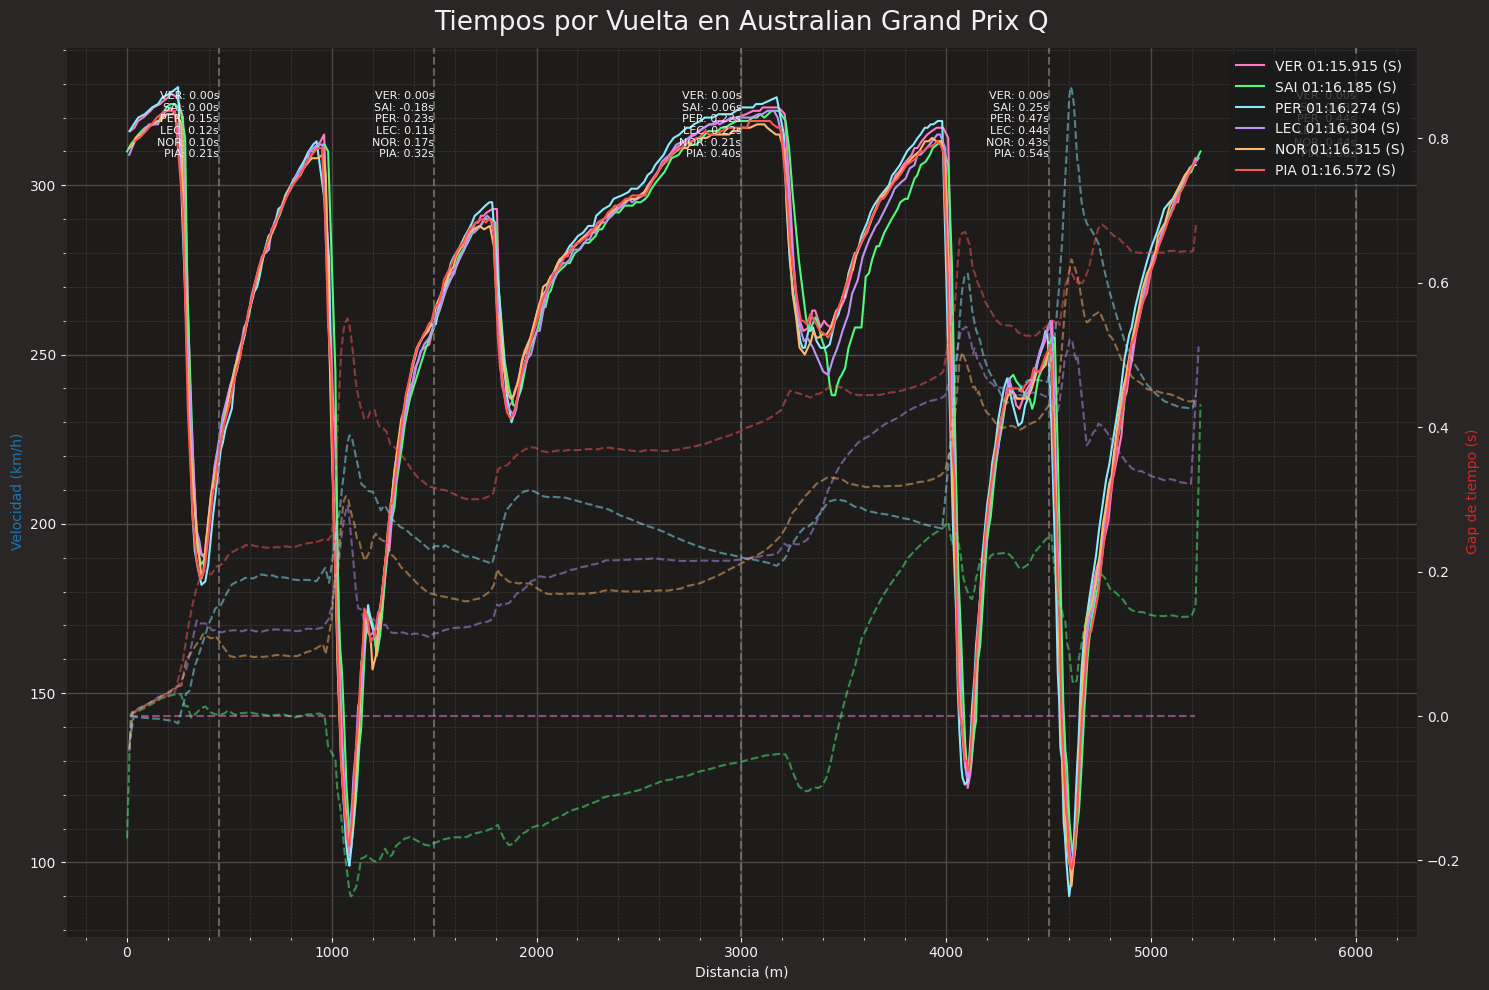

In [112]:
fastf1.plotting.setup_mpl()

vueltas_rapidas = [session.laps.pick_driver(corredor).pick_fastest() for corredor in session.laps['Driver'].unique()]
vueltas_rapidas = [vuelta for vuelta in vueltas_rapidas if pd.notna(vuelta['LapTime'])]

# Si LapTime ya está en segundos (o convertido a float), ordena directamente
vueltas_rapidas.sort(key=lambda x: x['LapTime'])

diez_vueltas_mas_rapidas = vueltas_rapidas[:6]

# Identificación de la vuelta de referencia (la mejor vuelta) y obtención de su telemetría
vuelta_referencia = vueltas_rapidas[0]
datos_coche_ref = vuelta_referencia.get_car_data().add_distance()
tiempo_ref = datos_coche_ref['Time'].dt.total_seconds()

# Preparación del gráfico con un tamaño mayor
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()  # Creación de un segundo eje para el gap de tiempo

# Definición de las distancias específicas para mostrar el gap de tiempo
distancias_puntos = [450, 1500, 3000, 4500, 6000]

# Inicialización de un diccionario para almacenar los gaps en puntos específicos
gaps_en_puntos = {distancia: [] for distancia in distancias_puntos}

# Procesamiento y gráfica de cada una de las vueltas seleccionadas
for vuelta in diez_vueltas_mas_rapidas:
    datos_coche = vuelta.get_car_data().add_distance()
    equipo = vuelta['Team']
    #color_equipo = fastf1.plotting.team_color(equipo)
    corredor = vuelta['Driver']
    tiempo_vuelta = format_lap_time(vuelta['LapTime'])  # Asegúrate de tener esta función definida
    
    # Gráfica de la velocidad en el primer eje y
    ax1.plot(datos_coche['Distance'], datos_coche['Speed'], label=f"{corredor} {tiempo_vuelta} ({vuelta['Compound'][0]})")
    
    # Cálculo y gráfica del gap de tiempo en el segundo eje y
    tiempo_vuelta_sec = datos_coche['Time'].dt.total_seconds()
    distancia = datos_coche['Distance']
    tiempo_ref_interp = np.interp(distancia, datos_coche_ref['Distance'], tiempo_ref)
    gap_tiempo = tiempo_vuelta_sec - tiempo_ref_interp
    ax2.plot(distancia, gap_tiempo, linestyle='--', alpha=0.5)

    # Cálculo del gap de tiempo en puntos específicos de distancia y almacenamiento para anotaciones posteriores
    for punto in distancias_puntos:
        gap_en_punto = np.interp(punto, distancia, gap_tiempo)
        gaps_en_puntos[punto].append(f"{corredor}: {gap_en_punto:.2f}s")

# Añadir líneas verticales y anotaciones de gap de tiempo en puntos específicos
for punto in distancias_puntos:
    ax1.axvline(x=punto, color='grey', linestyle='--', alpha=0.7)
    
    # Calcular el ajuste para bajar la anotación
    rango_y = ax1.get_ylim()[1] - ax1.get_ylim()[0]  # Diferencia entre el valor máximo y mínimo del eje y
    ajuste = rango_y * 0.05  # Ajuste del 5% del rango del eje y, modifica este valor según necesidad
    
    # Actualiza la posición de la anotación para moverla un poco más abajo
    texto_anotacion = "\n".join(gaps_en_puntos[punto])
    ax1.text(punto, ax1.get_ylim()[1] - ajuste, texto_anotacion, verticalalignment='top', horizontalalignment='right', fontsize=8)

# Configuración de los ejes y visualización final
ax1.set_xlabel('Distancia (m)')
ax1.set_ylabel('Velocidad (km/h)', color='tab:blue')
ax2.set_ylabel('Gap de tiempo (s)', color='tab:red')
ax1.legend()
plt.title(f'Tiempos por Vuelta en {grand_prix_name} {grand_prix_session}')
plt.tight_layout()
plt.show()

EXPORTA DATOS Y CREA GRAFICA

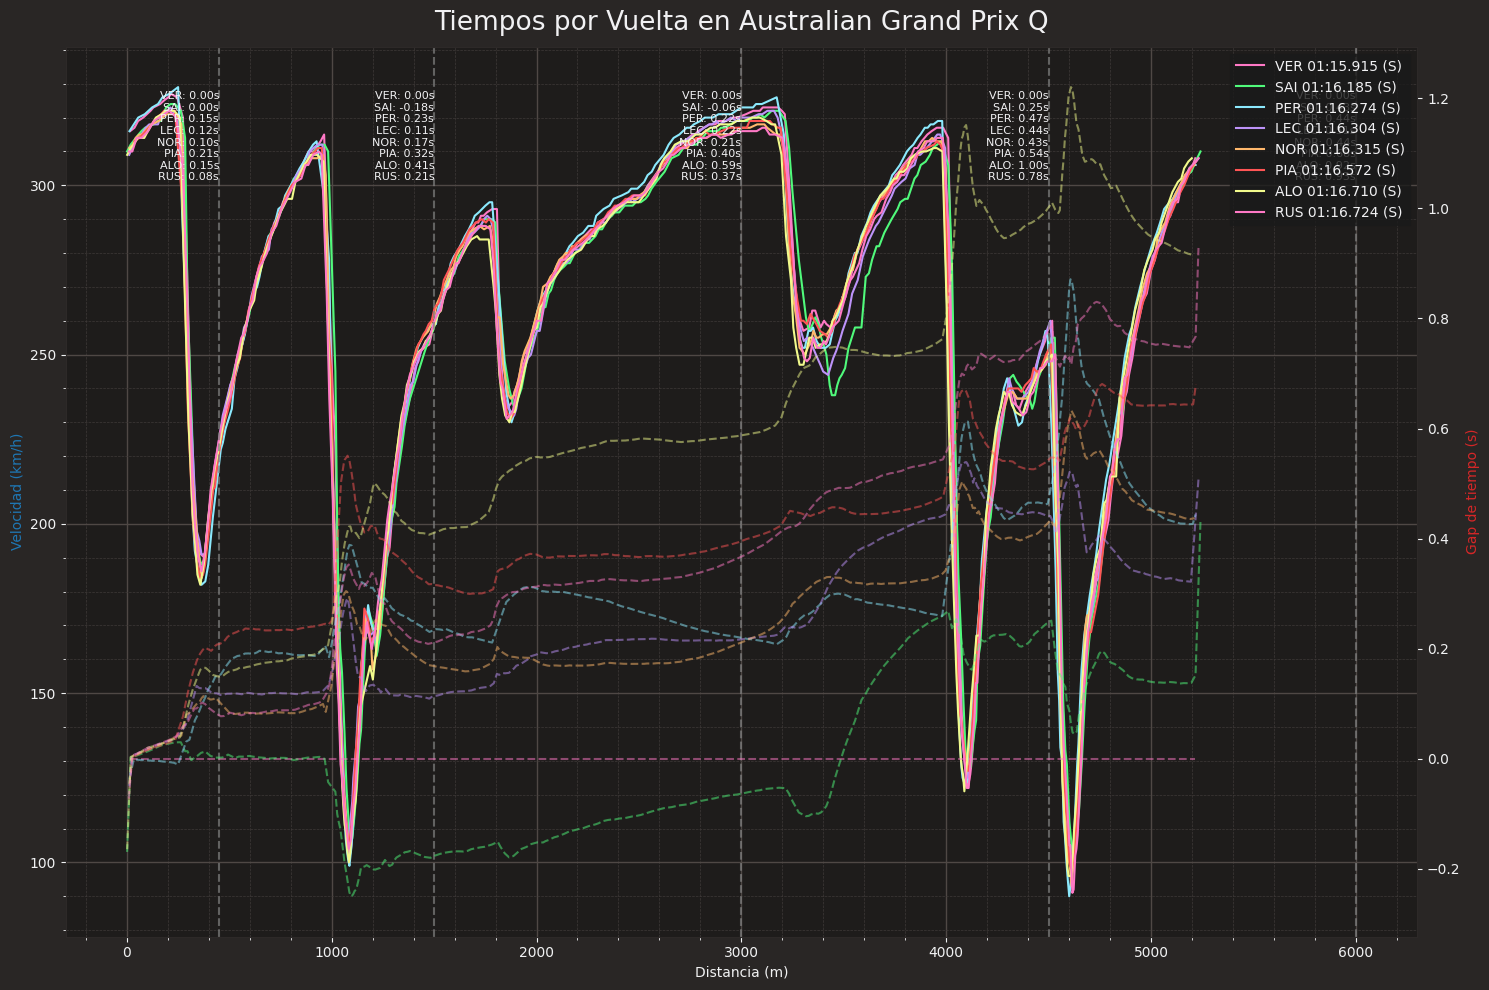

In [37]:
fastf1.plotting.setup_mpl()

vueltas_rapidas = [session.laps.pick_driver(corredor).pick_fastest() for corredor in session.laps['Driver'].unique()]
vueltas_rapidas = [vuelta for vuelta in vueltas_rapidas if pd.notna(vuelta['LapTime'])]

# Si LapTime ya está en segundos (o convertido a float), ordena directamente
vueltas_rapidas.sort(key=lambda x: x['LapTime'])

diez_vueltas_mas_rapidas = vueltas_rapidas[:8]

# Identificación de la vuelta de referencia (la mejor vuelta) y obtención de su telemetría
vuelta_referencia = vueltas_rapidas[0]
datos_coche_ref = vuelta_referencia.get_car_data().add_distance()
tiempo_ref = datos_coche_ref['Time'].dt.total_seconds()

# Preparación del gráfico con un tamaño mayor
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()  # Creación de un segundo eje para el gap de tiempo

# Definición de las distancias específicas para mostrar el gap de tiempo
distancias_puntos = [450, 1500, 3000, 4500, 6000]

# Inicialización de un diccionario para almacenar los gaps en puntos específicos
gaps_en_puntos = {distancia: [] for distancia in distancias_puntos}

# Lista para almacenar los datos antes de crear el DataFrame
datos_list = []

# Procesamiento y gráfica de cada una de las vueltas seleccionadas
for vuelta in diez_vueltas_mas_rapidas:
    datos_coche = vuelta.get_car_data().add_distance()
    equipo = vuelta['Team']
    #color_equipo = fastf1.plotting.team_color(equipo)
    corredor = vuelta['Driver']
    tiempo_vuelta = format_lap_time(vuelta['LapTime'])  # Asegúrate de tener esta función definida
    
    # Gráfica de la velocidad en el primer eje y
    ax1.plot(datos_coche['Distance'], datos_coche['Speed'], label=f"{corredor} {tiempo_vuelta} ({vuelta['Compound'][0]})")
    
    # Cálculo y gráfica del gap de tiempo en el segundo eje y
    tiempo_vuelta_sec = datos_coche['Time'].dt.total_seconds()
    distancia = datos_coche['Distance']
    tiempo_ref_interp = np.interp(distancia, datos_coche_ref['Distance'], tiempo_ref)
    gap_tiempo = tiempo_vuelta_sec - tiempo_ref_interp
    ax2.plot(distancia, gap_tiempo, linestyle='--', alpha=0.5)

    # Compilar datos para cada punto de distancia
    for d, s, g in zip(distancia, datos_coche['Speed'], gap_tiempo):
        datos_list.append({
            'Driver': corredor, 
            'LapTime': tiempo_vuelta, 
            'Distance': d, 
            'Speed': s, 
            'GapTime': g
        })

    # Cálculo del gap de tiempo en puntos específicos de distancia y almacenamiento para anotaciones posteriores
    for punto in distancias_puntos:
        gap_en_punto = np.interp(punto, distancia, gap_tiempo)
        gaps_en_puntos[punto].append(f"{corredor}: {gap_en_punto:.2f}s")

# Añadir líneas verticales y anotaciones de gap de tiempo en puntos específicos
for punto in distancias_puntos:
    ax1.axvline(x=punto, color='grey', linestyle='--', alpha=0.7)
    
    # Calcular el ajuste para bajar la anotación
    rango_y = ax1.get_ylim()[1] - ax1.get_ylim()[0]  # Diferencia entre el valor máximo y mínimo del eje y
    ajuste = rango_y * 0.05  # Ajuste del 5% del rango del eje y, modifica este valor según necesidad
    
    # Actualiza la posición de la anotación para moverla un poco más abajo
    texto_anotacion = "\n".join(gaps_en_puntos[punto])
    ax1.text(punto, ax1.get_ylim()[1] - ajuste, texto_anotacion, verticalalignment='top', horizontalalignment='right', fontsize=8)

# Configuración de los ejes y visualización final
ax1.set_xlabel('Distancia (m)')
ax1.set_ylabel('Velocidad (km/h)', color='tab:blue')
ax2.set_ylabel('Gap de tiempo (s)', color='tab:red')
ax1.legend()
plt.title(f'Tiempos por Vuelta en {grand_prix_name} {grand_prix_session}')
plt.tight_layout()
plt.show()

# Crear el DataFrame de pandas a partir de la lista de datos
datos_para_exportar = pd.DataFrame(datos_list)

# Exportar el DataFrame a un archivo CSV
ruta_archivo = 'datos_vueltas_rapidas.csv'
datos_para_exportar.to_csv(ruta_archivo, index=False)

TIEMPOS DE VUELTA MEDIO PRA EL TOP 8

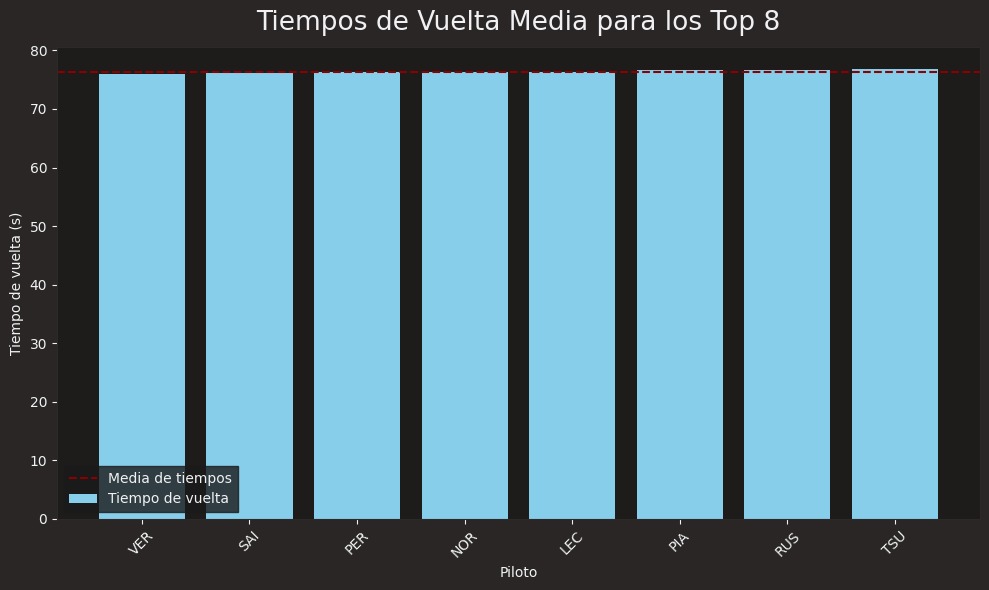

In [38]:


# Obtener los resultados finales y convertirlos a un DataFrame de pandas
results = session.results
# Asegúrate de que 'TotalTime' está en un formato que permita la comparación, como timedelta si no lo está ya
results['Time'] = pd.to_timedelta(results['Time'])

# Ordena los resultados por 'TotalTime'
results_sorted = results.sort_values(by='Time')

# Selecciona los primeros 8 registros después de ordenar
top8 = results_sorted.head(8)

# Obtener las vueltas rápidas de los pilotos que terminaron en el top 8
vueltas_rapidas_top8 = [session.laps.pick_driver(row['Abbreviation']).pick_fastest() for index, row in top8.iterrows()]
vueltas_rapidas_top8 = [vuelta for vuelta in vueltas_rapidas_top8 if pd.notna(vuelta['LapTime'])]

# Calcula la media de los tiempos de vuelta (en segundos)
tiempos_vuelta = [vuelta['LapTime'].total_seconds() for vuelta in vueltas_rapidas_top8]
media_tiempos = np.mean(tiempos_vuelta)

# Preparación del gráfico
plt.figure(figsize=(10, 6))
plt.bar(range(len(vueltas_rapidas_top8)), tiempos_vuelta, color='skyblue', label='Tiempo de vuelta')
plt.axhline(y=media_tiempos, color='darkred', linestyle='--', label='Media de tiempos')
plt.xticks(range(len(vueltas_rapidas_top8)), [vuelta['Driver'] for vuelta in vueltas_rapidas_top8], rotation=45)
plt.ylabel('Tiempo de vuelta (s)')
plt.xlabel('Piloto')
plt.title(f'Tiempos de Vuelta Media para los Top 8')
plt.legend()
plt.tight_layout()
plt.show()


TEAM COMPARISON

In [109]:
laps = session.laps.pick_quicklaps()
transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

# order the team from the fastest (lowest median lap time) tp slower
team_order = (
    transformed_laps[["Team", "LapTime (s)"]]
    .groupby("Team")
    .median()["LapTime (s)"]
    .sort_values()
    .index
)
print(team_order)

# make a color palette associating team names to hex codes
team_palette = {team: fastf1.plotting.team_color(team) for team in team_order}

Index(['Ferrari', 'Red Bull Racing', 'McLaren', 'Mercedes', 'Aston Martin',
       'Williams', 'RB', 'Haas F1 Team', 'Kick Sauber', 'Alpine'],
      dtype='object', name='Team')


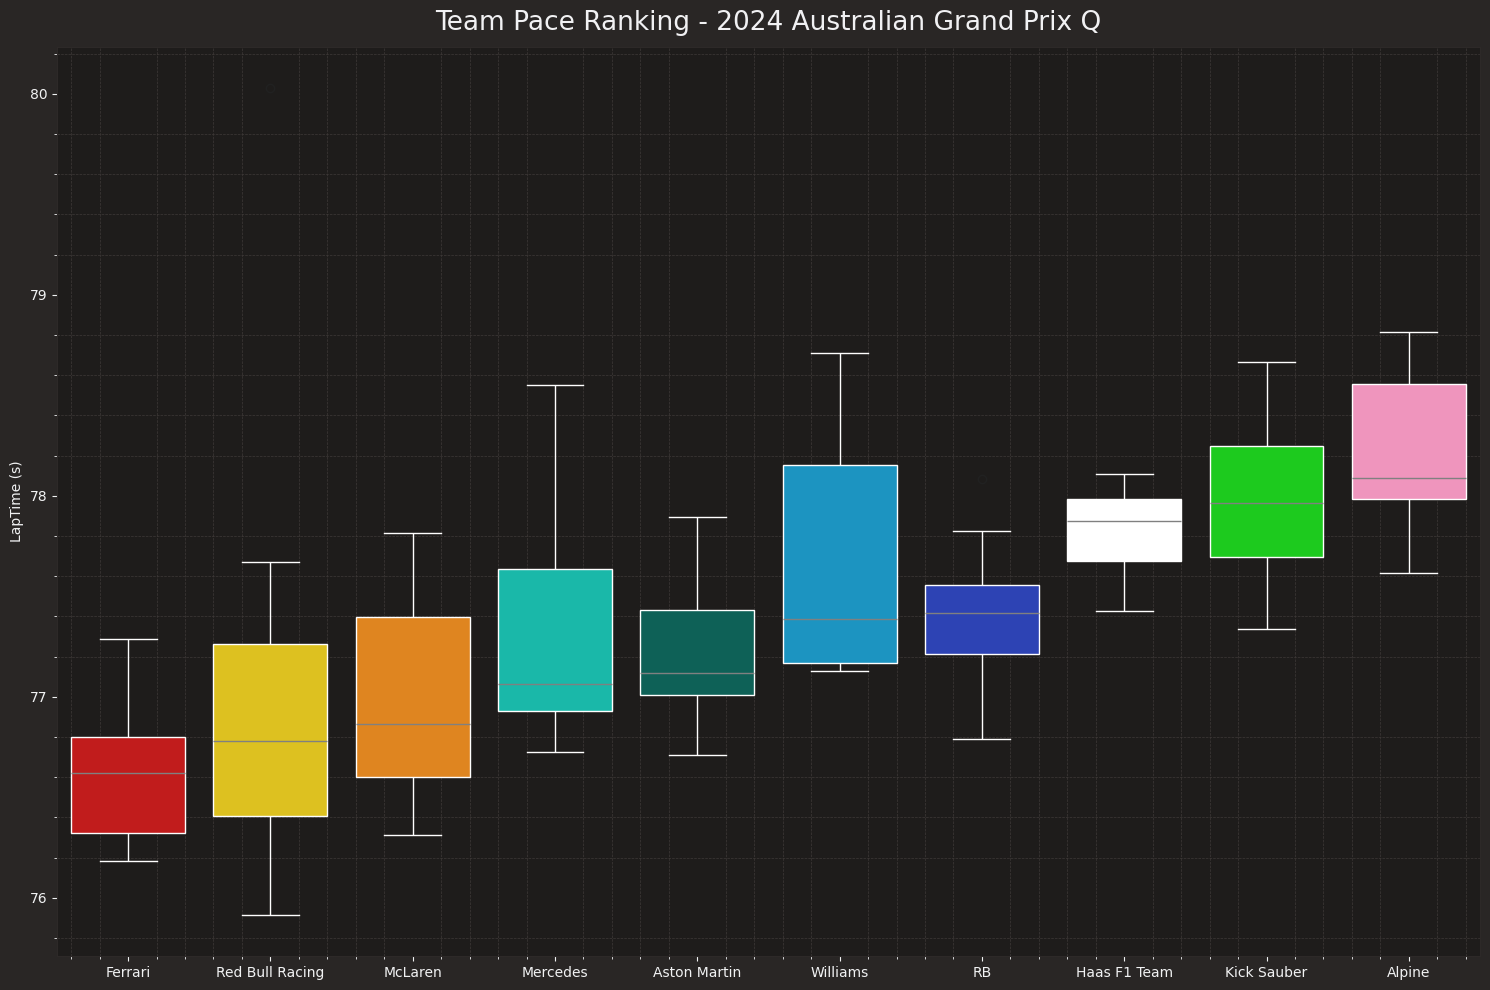

In [110]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(
    data=transformed_laps,
    x="Team",
    y="LapTime (s)",
    hue="Team",
    order=team_order,
    palette=team_palette,
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
)

plt.title(f"Team Pace Ranking - {grand_prix_year} {grand_prix_name} {grand_prix_session}")
plt.grid(visible=False)

# x-label is redundant
ax.set(xlabel=None)
plt.tight_layout()
plt.show()

Análisis de estrategias de neumatico

In [160]:
# Verificando los valores únicos en la columna 'DeletedReason'
unique_deleted_reasons = laps['Deleted'].unique()

print(unique_deleted_reasons)

[False]


In [164]:
def drivers_sorted_by_final_time(laps):
    # Trabajando con una copia para evitar SettingWithCopyWarning
    laps = laps.copy()
    # Calculando el tiempo total en pista para cada piloto
    laps['TotalTime'] = laps.groupby('Driver')['LapTime'].transform('sum')

    # Calculando el número total de vueltas completadas por cada piloto
    laps['TotalLaps'] = laps.groupby('Driver')['LapNumber'].transform('max')

    # Agregando una columna con el último LapStartTime más LapTime como aproximación del tiempo total en pista para quien no completó todas las vueltas
    laps['EndTime'] = laps['LapStartTime'] + laps['LapTime']

    # Obteniendo el tiempo final en pista para cada piloto (útil para aquellos que no completaron la carrera)
    final_times = laps.groupby('Driver')['EndTime'].max()

    # Creando un DataFrame con el resumen de los resultados
    driver_results = pd.DataFrame({
        'TotalLaps': laps.groupby('Driver')['TotalLaps'].first(),
        'TotalTime': laps.groupby('Driver')['TotalTime'].first(),
        'FinalTime': final_times
    }).reset_index()

    # Ordenando los pilotos primero por TotalLaps (descendente) y luego por FinalTime (ascendente)
    driver_results_sorted = driver_results.sort_values(by=['TotalLaps', 'FinalTime'], ascending=[False, True])

    return driver_results_sorted
print(drivers_sorted_by_final_time(laps))


   Driver  TotalLaps              TotalTime              FinalTime
14    SAI       58.0 0 days 01:18:58.468000 0 days 02:18:56.419000
6     LEC       58.0 0 days 01:18:58.689000 0 days 02:18:58.785000
8     NOR       58.0 0 days 01:19:02.963000 0 days 02:19:02.323000
11    PIA       58.0 0 days 01:19:31.577000 0 days 02:19:32.189000
10    PER       58.0 0 days 01:19:50.724000 0 days 02:19:52.728000
1     ALO       58.0 0 days 01:20:13.332000 0 days 02:20:17.411000
15    STR       58.0 0 days 01:20:27.230000 0 days 02:20:29.641000
16    TSU       58.0 0 days 01:20:29.139000 0 days 02:20:32.020000
5     HUL       58.0 0 days 01:20:34.476000 0 days 02:20:40.972000
13    RUS       57.0 0 days 01:16:32.824000 0 days 02:16:34.310000
7     MAG       57.0 0 days 01:18:55.457000 0 days 02:19:00.500000
0     ALB       57.0 0 days 01:18:56.100000 0 days 02:19:01.428000
12    RIC       57.0 0 days 01:19:00.706000 0 days 02:19:07.927000
3     GAS       57.0 0 days 01:19:25.492000 0 days 02:19:32.37

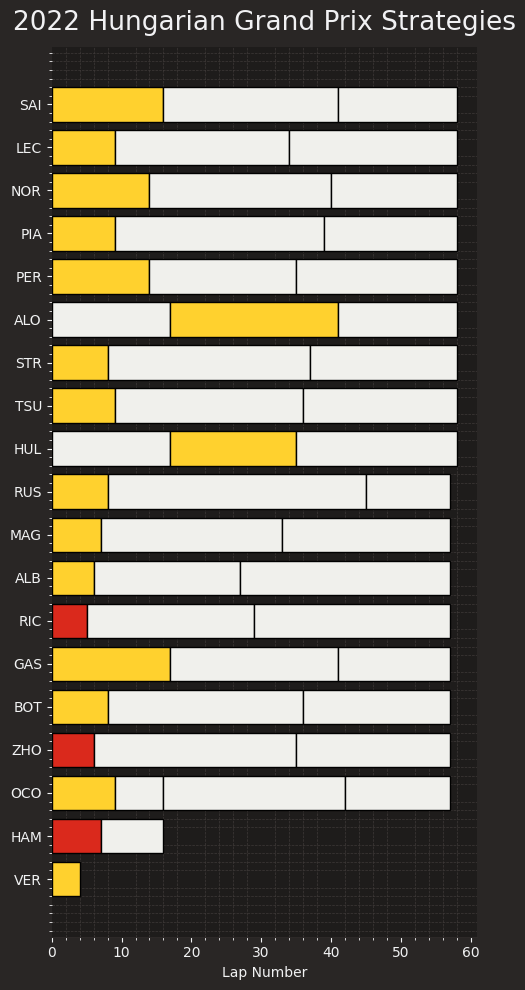

In [165]:
laps = session.laps
#drivers = session.drivers
drivers = drivers_sorted_by_final_time(laps)['Driver']
drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers]
stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]

stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()
stints = stints.rename(columns={"LapNumber": "StintLength"})

for drv in session.drivers:
    drv_laps = session.laps.pick_driver(drv)

fig, ax = plt.subplots(figsize=(5, 10))

for driver in drivers:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=fastf1.plotting.COMPOUND_COLORS[row["Compound"]],
            edgecolor="black",
            fill=True
        )

        previous_stint_end += row["StintLength"]


plt.title("2022 Hungarian Grand Prix Strategies")
plt.xlabel("Lap Number")
plt.grid(False)
# invert the y-axis so drivers that finish higher are closer to the top
ax.invert_yaxis()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

Gráfica de tiempos por vuelta y neumatico

In [52]:
def normalize_to_range(values, new_min=0, new_max=5, adjust=50):
    # Restar 50 a todos los valores antes de la normalización
    adjusted_values = values - adjust
    
    old_min = np.min(adjusted_values)
    old_max = np.max(adjusted_values)
    # Aplicar la fórmula de normalización a los valores ajustados
    scaled_values = new_min + ((adjusted_values - old_min) * (new_max - new_min) / (old_max - old_min))
    return scaled_values


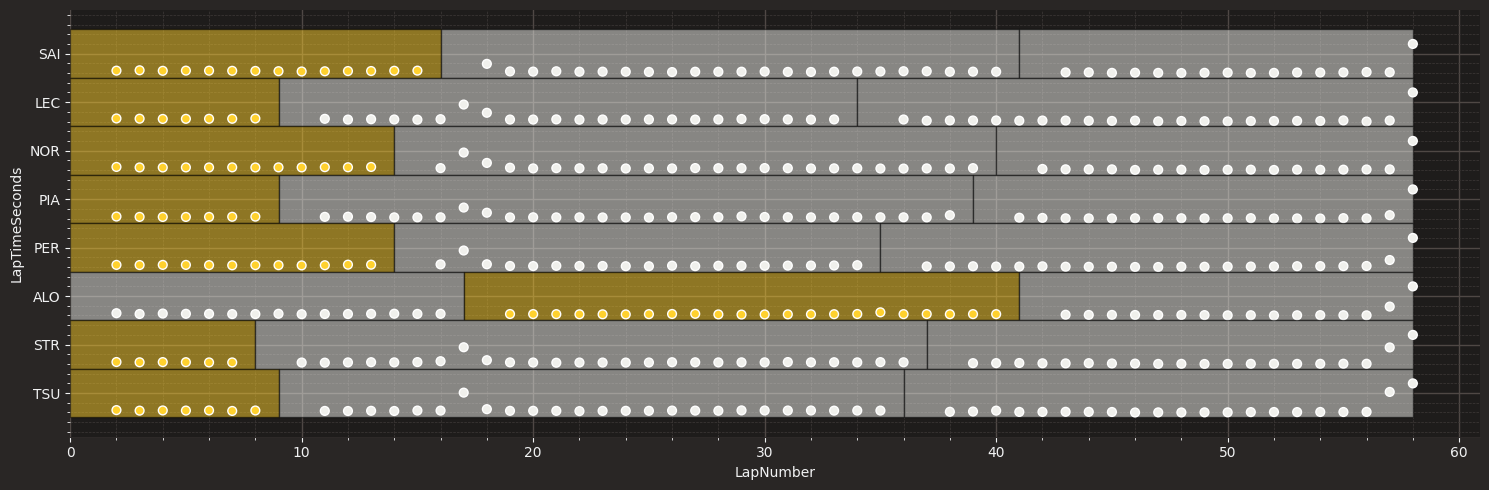

In [167]:

laps = session.laps
#drivers = session.drivers
#drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers][1:4]
drivers = drivers_sorted_by_final_time(laps)['Driver'][:8]
stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
#print(stints)
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()
stints = stints.rename(columns={"LapNumber": "StintLength"})


fig, ax = plt.subplots(figsize=(15, 5))

# Variables para controlar el layout de las barras
bar_height = 1
current_bottom = 0

###fig, ax = plt.subplots(figsize=(5, 10))

compound_opacity = {
    'soft': 0.6,
    'medium': 0.7,
    'hard': 0.8
    # Añade más compuestos y opacidades según sea necesario
}

for driver in drivers:
    driver_stints = stints.loc[stints['Driver'] == driver]
    driver_laps = laps[laps['Driver'] == driver]
    
    previous_stint_end = 0
    for _, row in driver_stints.iterrows():
        opacity = compound_opacity.get(row['Compound'], 0.5)  # Valor por defecto si el compuesto no está en el diccionario
        
        # Dibujar barra para el stint
        ax.barh(
            y=current_bottom,
            width=row['StintLength'],
            left=previous_stint_end,
            color=fastf1.plotting.COMPOUND_COLORS.get(row['Compound'], 'grey'),
            edgecolor='black',
            height=bar_height,
            alpha=opacity
        )
        previous_stint_end += row['StintLength']
    
    # Dibujar puntos para los tiempos por vuelta
    #driver_laps['LapTimeSeconds'] = driver_laps['LapTime'].dt.total_seconds()
    driver_laps = driver_laps.copy()
    #print(driver_laps['PitInTime'][6])

    driver_laps['LapTimeSeconds'] = driver_laps['LapTime'].dt.total_seconds()

    # Luego, establecemos 'LapTimeSeconds' como NaN para las vueltas en las que el piloto estuvo en el pitstop
    # Esto se hace verificando si 'PitInTime' o 'PitOutTime' tienen algún valor (no son nulos)
    driver_laps.loc[(driver_laps['PitInTime'].notna()) | (driver_laps['PitOutTime'].notna()), 'LapTimeSeconds'] = np.nan


    #print(driver_laps['LapTimeSeconds'])
    #print(pd.Categorical(driver_laps['Driver']).codes + current_bottom + bar_height / 2 + normalize_to_range(driver_laps['LapTimeSeconds']))
    sns.scatterplot(
        data=driver_laps,
        x='LapNumber',
        y=pd.Categorical(driver_laps['Driver']).codes + current_bottom + normalize_to_range(driver_laps['LapTimeSeconds'],0.4,-0.2,90),  # Ajustar y para alinear con la barra del piloto
        hue='Compound',
        palette=fastf1.plotting.COMPOUND_COLORS,
        s=40,
        linewidth=1,
        legend=False,  # Cambiar a 'brief' o 'full' si quieres una leyenda
        ax=ax
    )
    
    current_bottom += 1  # Ajustar para la siguiente barra

ax.set_yticks(range(len(drivers)))
ax.set_yticklabels(drivers)
ax.invert_yaxis()  # Opcional, dependiendo de cómo quieras visualizar los pilotos

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

Ficha grande

In [168]:
" Add team logo "
#import matplotlib.pyplot as plt
#from matplotlib.offsetbox import OffsetImage, AnnotationBbox
#from PIL import Image
#import numpy as np

def add_team_logo(ax, team_name, zoom=0.2):
    """
    Carga y muestra el escudo del equipo en el eje proporcionado.
    
    Parámetros:
    ax -- el eje de Matplotlib donde se colocará la imagen.
    team_name -- el nombre del equipo, que corresponde al nombre del archivo de imagen.
    zoom -- el nivel de zoom para la imagen.
    """
    base_path = './images/teams/'  # Actualiza con la ruta correcta a tus imágenes
    file_path = f'{base_path}{team_name}.png'  # Asume que el nombre de la imagen es el mismo que el nombre del equipo
    
    try:
        # Carga la imagen
        img = Image.open(file_path)
        
        # Convierte la imagen PIL a un objeto de imagen que Matplotlib pueda manejar
        img = np.array(img)
        
        # Crear el objeto OffsetImage
        imagebox = OffsetImage(img, zoom=zoom)
        
        # Crear el objeto AnnotationBbox y colocarlo en el eje
        ab = AnnotationBbox(imagebox, (0.5, 0.5), frameon=False, boxcoords="axes fraction")
        ax.add_artist(ab)
        
    except FileNotFoundError:
        print(f'El archivo {file_path} no existe.')



['SAI', 'LEC', 'NOR', 'PIA', 'PER', 'ALO', 'STR', 'TSU', 'HUL', 'RUS', 'MAG', 'ALB', 'RIC', 'GAS', 'BOT', 'ZHO', 'OCO', 'HAM', 'VER']
DriverNumber                                                         55
BroadcastName                                                   C SAINZ
Abbreviation                                                        SAI
DriverId                                                               
TeamName                                                        Ferrari
TeamColor                                                        E80020
TeamId                                                                 
FirstName                                                        Carlos
LastName                                                          Sainz
FullName                                                   Carlos Sainz
HeadshotUrl           https://media.formula1.com/d_driver_fallback_i...
CountryCode                                                         ESP
Po

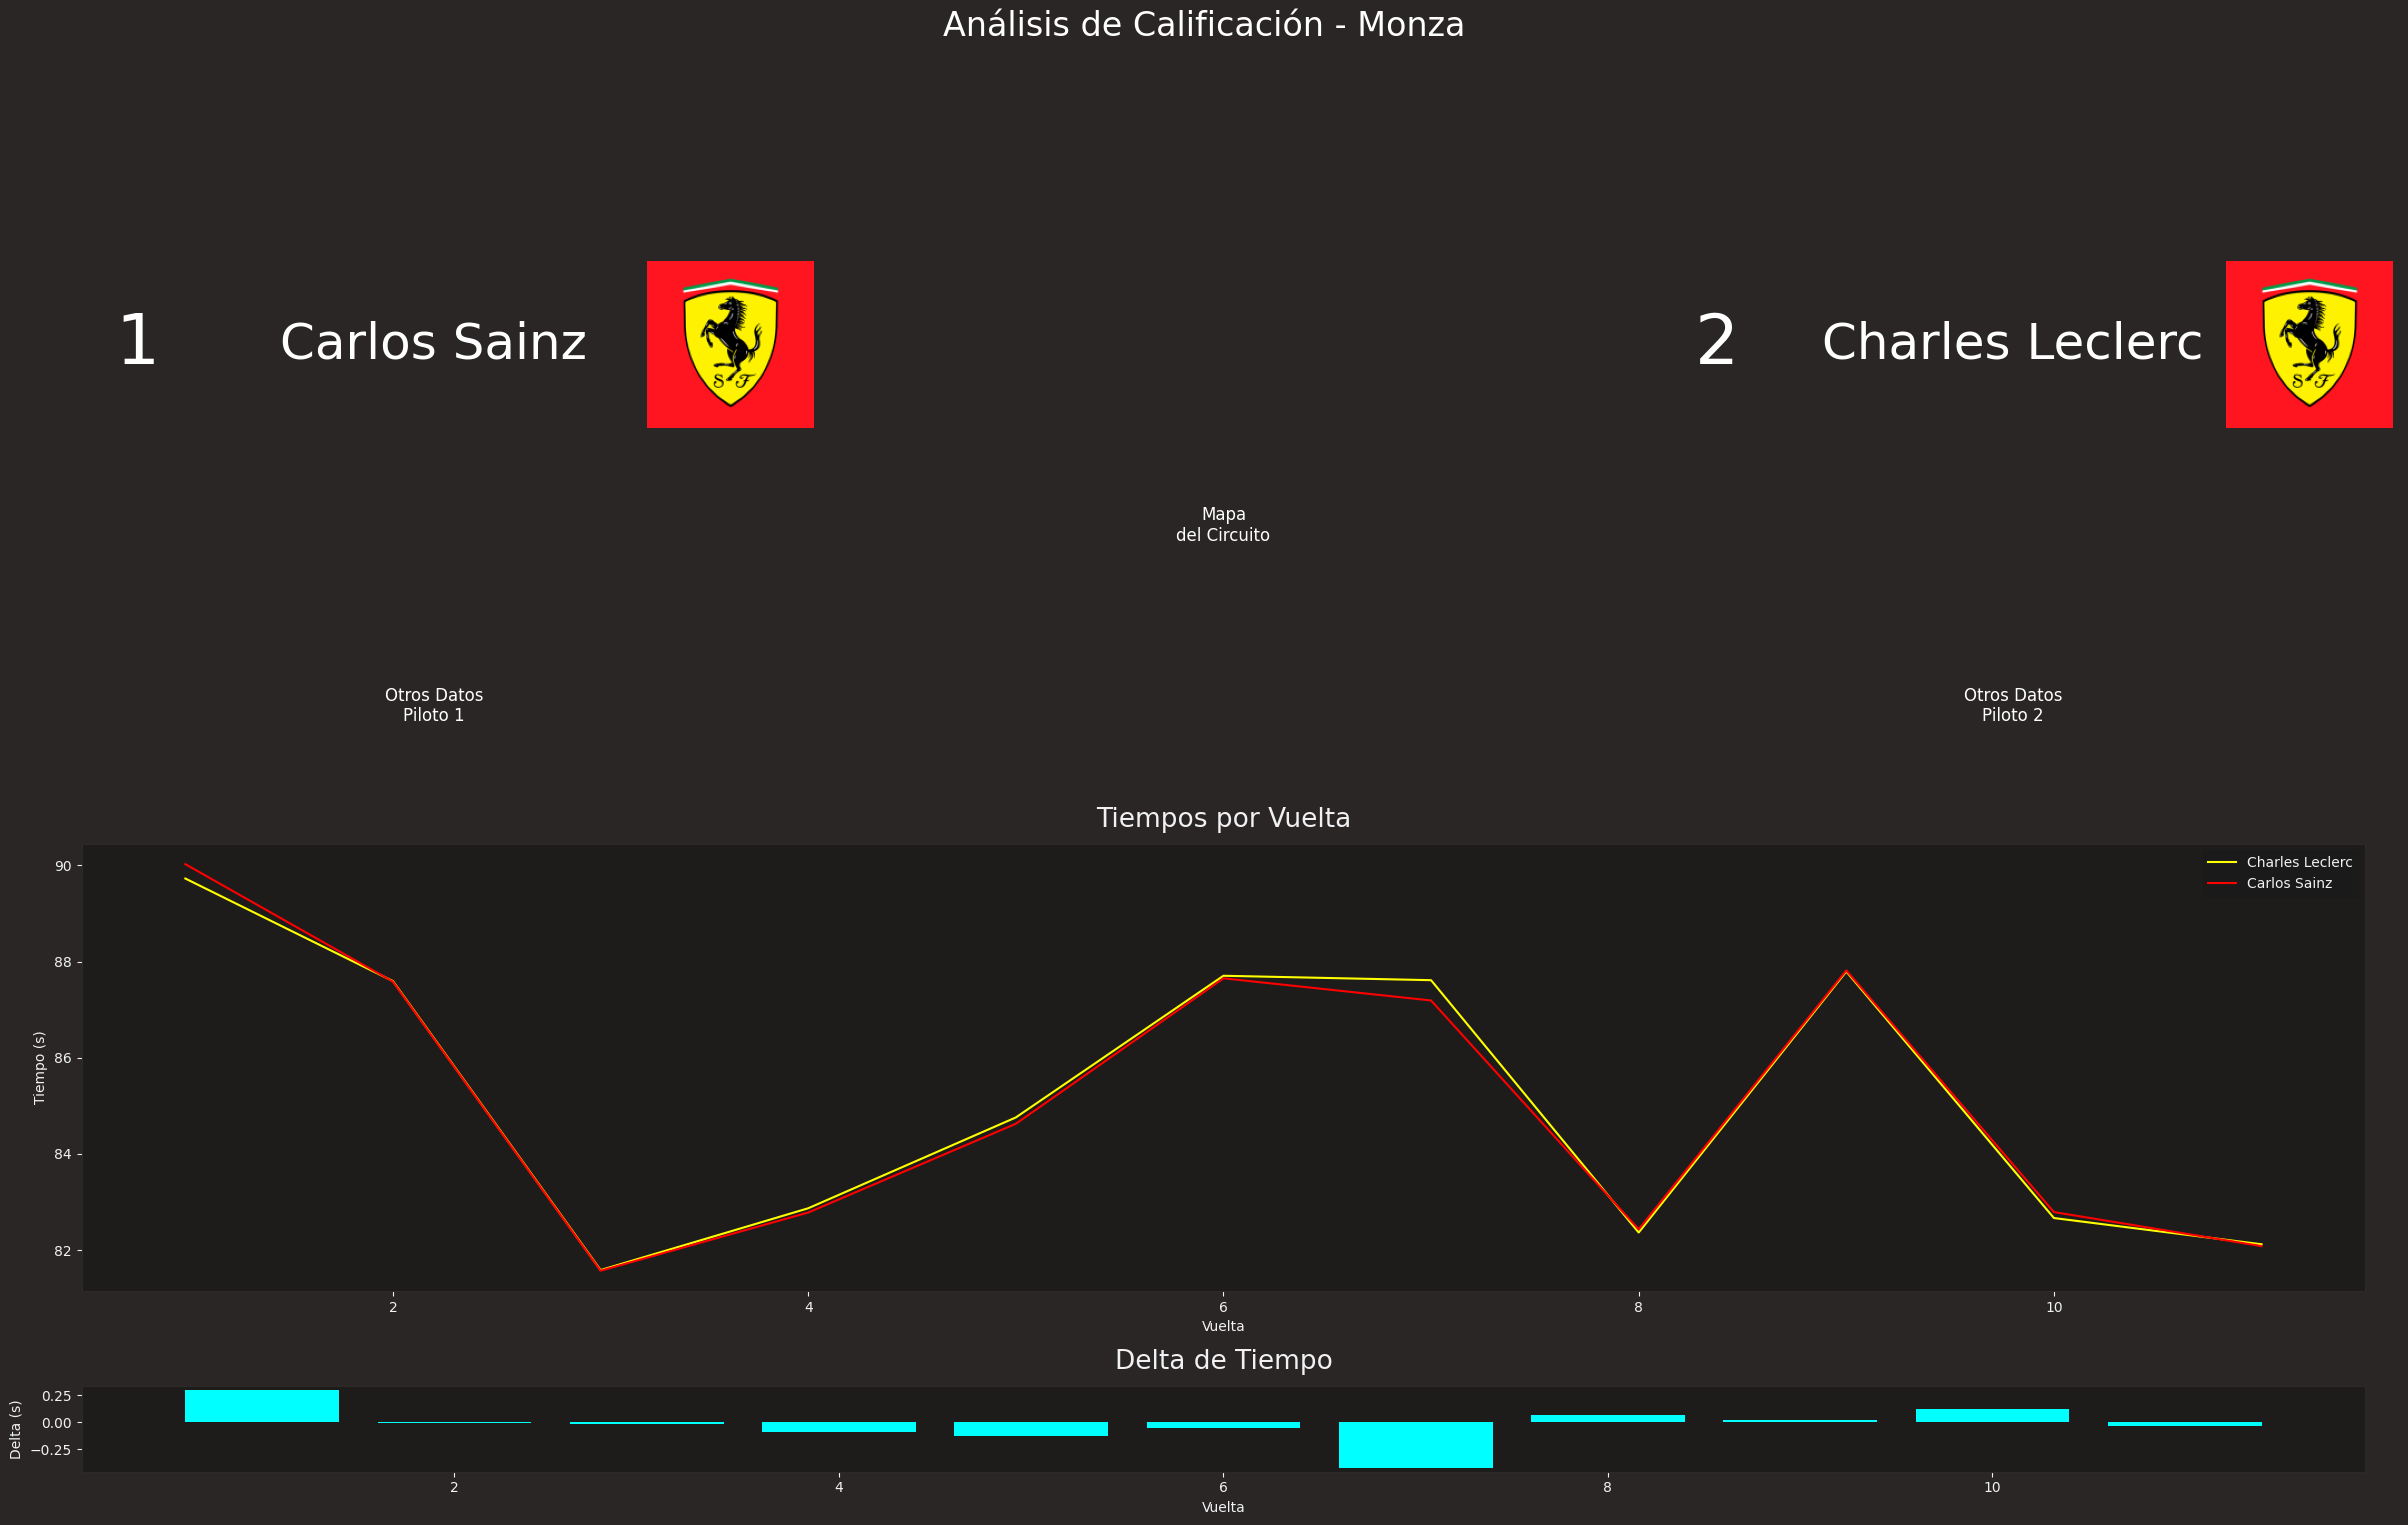

In [186]:
#import numpy as np
#import matplotlib.pyplot as plt
#from matplotlib import gridspec

drivers_to_compare = ['SAI', 'LEC']
drivers_sorted = drivers_sorted_by_final_time(laps)['Driver'].to_list()
print(drivers_sorted)

driver_1 = session.get_driver(drivers_to_compare[0])
print(driver_1)
driver_2 = session.get_driver(drivers_to_compare[1])

font_driver_number = 50
font_driver_name = 36

# Datos simulados
n_vueltas = 11
vueltas = np.arange(1, n_vueltas + 1)
tiempos_leclerc = np.random.uniform(80, 90, size=n_vueltas)
tiempos_sainz = tiempos_leclerc + np.random.normal(0, 0.2, size=n_vueltas)  # tiempos similares con variación normal
delta_tiempo = tiempos_sainz - tiempos_leclerc

# Iniciar la figura con GridSpec
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(8, 12, figure=fig)

# Título grande del header
fig.suptitle('Análisis de Calificación - Monza', fontsize=24, color='white')

# Información del piloto 1
ax1 = fig.add_subplot(gs[1, 0])
ax1.text(0.5, 0.5, f"{drivers_sorted.index(drivers_to_compare[0]) + 1}", ha='center', va='center', fontsize=font_driver_number, color='white')
ax1.axis('off')

ax2 = fig.add_subplot(gs[1, 1:3])
ax2.text(0.5, 0.5, f"{driver_1['FullName']}", ha='center', va='center', fontsize=font_driver_name, color='white')
ax2.axis('off')

ax3 = fig.add_subplot(gs[1, 3])
#ax3.text(0.5, 0.5, 'Escudo', ha='center', va='center', fontsize=12, color='yellow')
add_team_logo(ax3, f"{driver_1['TeamName']}", zoom=0.8)  # reemplaza 'nombre_equipo' con el nombre correspondiente
ax3.axis('off')

# Información del piloto 2
ax4 = fig.add_subplot(gs[1, 8])
ax4.text(0.5, 0.5, f"{drivers_sorted.index(drivers_to_compare[1]) + 1}", ha='center', va='center', fontsize=font_driver_number, color='white')
ax4.axis('off')

ax5 = fig.add_subplot(gs[1, 9:11])
ax5.text(0.5, 0.5, f"{driver_2['FullName']}", ha='center', va='center', fontsize=font_driver_name, color='white')
ax5.axis('off')

ax6 = fig.add_subplot(gs[1, 11])
#ax6.text(0.5, 0.5, 'Escudo', ha='center', va='center', fontsize=12, color='red')
add_team_logo(ax6, f"{driver_2['TeamName']}", zoom=0.8)  # reemplaza 'nombre_equipo' con el nombre correspondiente
ax6.axis('off')

# Otros datos para los pilotos (simulados por texto por ahora)
ax7 = fig.add_subplot(gs[3, 0:4])
ax7.text(0.5, 0.5, 'Otros Datos\nPiloto 1', ha='center', va='center', fontsize=12, color='white')
ax7.axis('off')

ax8 = fig.add_subplot(gs[3, 8:12])
ax8.text(0.5, 0.5, 'Otros Datos\nPiloto 2', ha='center', va='center', fontsize=12, color='white')
ax8.axis('off')

# Mapa del circuito en el centro
ax_map = fig.add_subplot(gs[1:4, 4:8])
ax_map.text(0.5, 0.5, 'Mapa\ndel Circuito', ha='center', va='center', fontsize=12, color='white')
ax_map.axis('off')

# Tiempos por vuelta de ambos pilotos
ax_time_comparison = fig.add_subplot(gs[4:7, :])
ax_time_comparison.plot(vueltas, tiempos_leclerc, label='Charles Leclerc', color='yellow')
ax_time_comparison.plot(vueltas, tiempos_sainz, label='Carlos Sainz', color='red')
ax_time_comparison.set_title('Tiempos por Vuelta')
ax_time_comparison.set_xlabel('Vuelta')
ax_time_comparison.set_ylabel('Tiempo (s)')
ax_time_comparison.legend()

# Delta de tiempo entre ellos en la fila 8
ax_delta_time = fig.add_subplot(gs[7, :])
ax_delta_time.bar(vueltas, delta_tiempo, color='cyan')
ax_delta_time.set_title('Delta de Tiempo')
ax_delta_time.set_xlabel('Vuelta')
ax_delta_time.set_ylabel('Delta (s)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta el layout para el título
plt.show()


Mapa de sectores


Mejor Sector 1: 0 days 00:00:26.577000
Mejor Sector 2: 0 days 00:00:17.457000
Mejor Sector 3: 0 days 00:00:32.660000
Mejor Sector 1 G: 0 days 00:00:26.222000 SAI
Mejor Sector 2 G: 0 days 00:00:17.289000 PER
Mejor Sector 3 G: 0 days 00:00:32.338000 VER


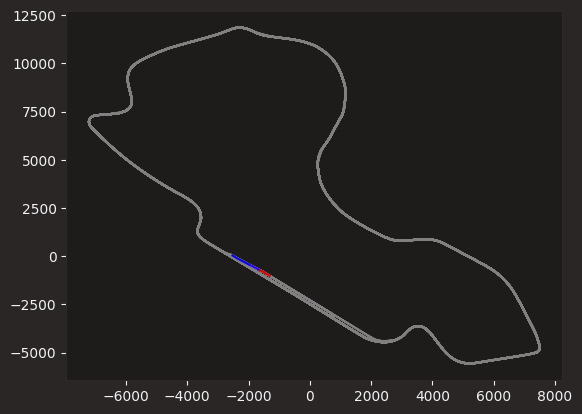

In [56]:
import fastf1 as ff1
from fastf1 import plotting
import matplotlib.pyplot as plt

# Configuración para que las gráficas se vean más estilizadas
plotting.setup_mpl()

# Supongamos que tenemos dos pilotos de interés: VER (Verstappen) y HAM (Hamilton)
piloto1_code = 'ALO'
piloto2_code = 'HAM'

# Obtener las vueltas más rápidas para los pilotos de interés
vuelta_piloto1 = laps.pick_driver(piloto1_code)
# Encuentra el mejor tiempo para cada sector
mejor_sector1 = vuelta_piloto1['Sector1Time'].min()
mejor_sector2 = vuelta_piloto1['Sector2Time'].min()
mejor_sector3 = vuelta_piloto1['Sector3Time'].min()

print(f"Mejor Sector 1: {mejor_sector1}")
print(f"Mejor Sector 2: {mejor_sector2}")
print(f"Mejor Sector 3: {mejor_sector3}")

#vuelta_piloto1 = laps.pick_driver(piloto1_code).pick_fastest()
vuelta_piloto1 = laps.pick_driver(piloto1_code)

# Encuentra el mejor tiempo para cada sector
idx_mejor_sector1 = session.laps['Sector1Time'].idxmin()
idx_mejor_sector2 = session.laps['Sector2Time'].idxmin()
idx_mejor_sector3 = session.laps['Sector3Time'].idxmin()

piloto_mejor_sector1 = session.laps.loc[idx_mejor_sector1, 'Driver']
piloto_mejor_sector2 = session.laps.loc[idx_mejor_sector2, 'Driver']
piloto_mejor_sector3 = session.laps.loc[idx_mejor_sector3, 'Driver']

mejor_sector1_global = session.laps.loc[idx_mejor_sector1, 'Sector1Time']
mejor_sector2_global = session.laps.loc[idx_mejor_sector2, 'Sector2Time']
mejor_sector3_global = session.laps.loc[idx_mejor_sector3, 'Sector3Time']

print(f"Mejor Sector 1 G: {mejor_sector1_global} {piloto_mejor_sector1}")
print(f"Mejor Sector 2 G: {mejor_sector2_global} {piloto_mejor_sector2}")
print(f"Mejor Sector 3 G: {mejor_sector3_global} {piloto_mejor_sector3}")


# Graficar el mapa del circuito
plt.plot(vuelta_piloto1.telemetry['X'], vuelta_piloto1.telemetry['Y'], color='grey')

# Asumiendo que tienes acceso a los índices de los sectores (esto es un supuesto simplificado)
# En la práctica, necesitarías datos reales sobre los límites de cada sector en el circuito
sector1_indices = slice(0, 10)  # Suposición simplificada de los índices para el sector 1
sector2_indices = slice(10, 20) # Suposición para el sector 2
sector3_indices = slice(20, 30) # Suposición para el sector 3


# Resaltar los sectores más rápidos con los colores de los pilotos
plt.plot(vuelta_piloto1.telemetry['X'][sector1_indices], vuelta_piloto1.telemetry['Y'][sector1_indices], color=name_to_color_hex(piloto_mejor_sector1))
plt.plot(vuelta_piloto1.telemetry['X'][sector2_indices], vuelta_piloto1.telemetry['Y'][sector2_indices], color=name_to_color_hex(piloto_mejor_sector2))
plt.plot(vuelta_piloto1.telemetry['X'][sector3_indices], vuelta_piloto1.telemetry['Y'][sector3_indices], color=name_to_color_hex(piloto_mejor_sector3))

# Mostrar la gráfica
plt.show()


In [58]:
# Supongamos que tenemos dos pilotos de interés: VER (Verstappen) y HAM (Hamilton)
piloto1_code = 'VER'
piloto2_code = 'HAM'

# Obtener las vueltas más rápidas para los pilotos de interés
vuelta_piloto1 = laps.pick_driver(piloto1_code).pick_fastest()
vuelta_piloto2 = laps.pick_driver(piloto2_code).pick_fastest()

# Obtener la telemetría de las vueltas más rápidas
telem_piloto1 = vuelta_piloto1.get_telemetry()
telem_piloto2 = vuelta_piloto2.get_telemetry()

plt.figure(figsize=(12, 10))

# Suponiendo que el circuito se puede dividir en 5 secciones principales
num_secciones = 100
distancia_total = max(telem_piloto1['Distance'].max(), telem_piloto2['Distance'].max())
seccion_longitud = distancia_total / num_secciones

for i in range(num_secciones):
    inicio_seccion = i * seccion_longitud
    fin_seccion = (i + 1) * seccion_longitud
    
    # Filtrar los datos de telemetría para esta sección
    seccion_piloto1 = telem_piloto1[(telem_piloto1['Distance'] >= inicio_seccion) & (telem_piloto1['Distance'] < fin_seccion)]
    seccion_piloto2 = telem_piloto2[(telem_piloto2['Distance'] >= inicio_seccion) & (telem_piloto2['Distance'] < fin_seccion)]
    
    # Alternar colores para las secciones; esto es ilustrativo
    color = 'red' if i % 2 == 0 else 'blue'
    
    plt.plot(seccion_piloto1['Y']*-1, seccion_piloto1['X'], color=color, linewidth=2)
    plt.plot(seccion_piloto2['Y']*-1, seccion_piloto2['X'], color=color, linewidth=2)

plt.title('Mapa del Circuito con Secciones Destacadas')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')  # Mantiene la proporción
plt.show()



KeyboardInterrupt: 

el codigo de github


In [59]:
laps = session.laps
laps = laps.pick_quicklaps(threshold=1.03)
# Suponiendo que quieres seguir usando una selección de conductores específicos
driver_list = ['HAM', 'VER']

telemetry = pd.DataFrame()
for driver in driver_list:
    driver_telemetry = laps.pick_driver(driver).pick_fastest().get_telemetry().add_distance()
    driver_telemetry['Driver'] = driver
    # Aquí, asigna un color genérico en lugar de usar driver_year_color
    driver_telemetry['Colour'] = driver_colors[driver]
    telemetry = pd.concat([telemetry, driver_telemetry])

telemetry = telemetry[['Distance', 'Speed', 'X', 'Y', 'Driver', 'Colour']]

print(telemetry)
# Define el número de minisectores
num_minisectors = 25
total_distance = telemetry['Distance'].max()
minisector_length = total_distance / num_minisectors

# Asigna minisectores
telemetry['Minisector'] = telemetry['Distance'].apply(lambda x: int(x // minisector_length) + 1)

# Identifica al conductor más rápido por minisector
fastest_per_minisector = telemetry.loc[telemetry.groupby('Minisector')['Speed'].idxmax()]

# Prepara los datos para la visualización
points = np.array(list(zip(fastest_per_minisector['X'], fastest_per_minisector['Y']))).reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors = fastest_per_minisector['Colour'].tolist()

# Visualización
fig, ax = plt.subplots()
lc = LineCollection(segments, colors=colors, linewidths=2)
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.show()



NameError: name 'driver_colors' is not defined

el codigo de github mejorado


In [60]:
laps = session.laps
laps = laps.pick_quicklaps(threshold=1.03)
# Suponiendo que quieres seguir usando una selección de conductores específicos
driver_list = ['LEC', 'SAI']

telemetry = pd.DataFrame()
for driver in driver_list:
    driver_telemetry = laps.pick_driver(driver).pick_fastest().get_telemetry().add_distance()
    driver_telemetry['Driver'] = driver
    driver_telemetry['Colour'] = driver_colors[driver]
    driver_number = laps.pick_driver(driver).iloc[0]['DriverNumber']
    driver_telemetry['DriverNumber'] = int(driver_number)

    # Intercambiamos las coordenadas X e Y y rotamos la X para poder mostrar el circuito correctamente
    driver_telemetry_x = driver_telemetry['X']
    driver_telemetry['X'] = driver_telemetry['Y'] * -1
    driver_telemetry['Y'] = driver_telemetry_x

    telemetry = pd.concat([telemetry, driver_telemetry])

telemetry = telemetry[['Distance', 'Speed', 'X', 'Y', 'Driver', 'DriverNumber', 'Colour']]

# Define el número de minisectores
num_minisectors = 2 #
total_distance = telemetry['Distance'].max()
minisector_length = total_distance / num_minisectors

#Assign distances to each minisector
minisectors = [0]

for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

# Assign minisector to every row in the telemetry data
telemetry['Minisector'] =  telemetry['Distance'].apply(
  lambda z: (
    minisectors.index(
      min(minisectors, key=lambda x: abs(x-z)))+1
  )
)

# Calculate fastest driver (highest average speed) per mini sector
average_speed = telemetry.groupby(['Minisector' , 'Driver'])['Speed'].mean().reset_index()

# Select the driver with the highest average speed
fastest_drivers = average_speed.loc[average_speed.groupby(['Minisector', 'Driver'])['Speed'].idxmax()]

#Perhaps for use later in interactive sector plot
b=fastest_drivers.sort_values(by=['Minisector', 'Speed'])  #try to have speed descending order?

# Sort to find fastest driver for each minisector
fastest_minisector = fastest_drivers.sort_values('Speed', ascending = False).drop_duplicates(['Minisector'])
fastest_minisector = fastest_minisector.sort_values(by = ['Minisector'])
fastest_minisector = fastest_minisector[[ 'Minisector', 'Driver' , 'Speed']].rename(columns={'Speed': 'Sector_avg_speed', 'Driver' : 'Fastest_driver'})

# Get rid of the speed column and rename the driver column
fastest_drivers = fastest_drivers[[ 'Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

# Join the fastest minisector dataframe with the full telemetry
# to merge minisector, fastest driver in each and avg speed in that minisector

telemetry = telemetry.merge(fastest_minisector, on=['Minisector'])

# Order the data by distance

telemetry = telemetry.sort_values(by=['Distance'])

# Assign integer value to the fastest driver in each minisector (driver number)
for driver in driver_list: 
    driver_number = telemetry[telemetry['Driver'] == driver].iloc[0]['DriverNumber']
    telemetry.loc[telemetry['Fastest_driver'] == driver , 'Fastest_driver_int'] = driver_number
            
# Get X, Y coordinates of the circuit
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

# Divide up the circuit into 2D into segments
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

print(segments.shape[0])
minisector_int = telemetry['Fastest_driver_int'].to_numpy().astype(float)
#minisector_str = telemetry['Fastest_driver_int']

minisector_fastest_drivers = telemetry['Fastest_driver'].unique()
minisector_fastest_drivers_num = telemetry['Fastest_driver_int'].unique()

minisector_colours = []

for driver in minisector_fastest_drivers:
   minisector_colours.append(name_to_color_hex(laps.pick_driver(driver).pick_fastest()['Driver']))
   
minisector_colours = np.array(minisector_colours)

minisector_details = pd.DataFrame({'Fastest_driver' : minisector_fastest_drivers, 'Fastest_driver_int' : minisector_fastest_drivers_num, 'Minisector_colours' :  minisector_colours }, columns=['Fastest_driver', 'Fastest_driver_int', 'Minisector_colours'])

# Sort order by driver number min to max. 
minisector_details = minisector_details.sort_values(by = ['Fastest_driver_int'])

# Get driver number, colour, name for plotting
num_list_ordered = minisector_details['Fastest_driver_int'].tolist()
colour_list_ordered = minisector_details['Minisector_colours'].tolist()
print(colour_list_ordered)
driver_name_ordered = minisector_details['Fastest_driver'].tolist()
print(driver_name_ordered)
############################################################################################################################################
"This seems to work despite but i dont really undertsand why"

#Quick fix to sort out colorbar error, add 1 to the last number
###num_list_ordered.insert(len(num_list_ordered),(num_list_ordered[-1] +1))

##############################################################################################################################

# Create figure and size of the figure
fig, ax = plt.rcParams['figure.figsize'] = [16, 9]
plt.figure(figsize=(10, 8))  # Tamaño en pulgadas

# Define the colour map using the driver colours
cmap = mpl.colors.ListedColormap(colour_list_ordered)
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = num_list_ordered
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Create a linecollection of segments using the colour map
lc_comp = LineCollection(segments, norm=norm, cmap=cmap)
lc_comp.set_array(minisector_int)
print(minisector_int.shape[0])
print(minisector_int)
lc_comp.set_linewidth(4)

# Plot the linecollection
plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.axis('off')

# For 1v1 driver vs driver
#plt.title((driver_list[0] + ' vs ' + driver_list[1] + ' ' + str(grand_prix_year) + ' ' + str(grand_prix_name_official) + ' ' + '\n' + 'Number of minisectors = ' + str(num_minisectors) ), fontsize = 20)

# For many drivers
#plt.title((str(session.weekend.year) + ' ' + str(session.weekend.name) + ' ' + str(session.name) + '\n' + 'Number of minisectors = ' + str(num_minisectors) ), fontproperties=prop, fontsize = 20)

# Construye la ruta del directorio
dir_path = f"images/generated/{grand_prix_year}/{grand_prix_weekend}/{grand_prix_session}/{driver_list[0]}vs{driver_list[1]}"
# Asegúrate de que el directorio exista
os.makedirs(dir_path, exist_ok=True)
# Ahora puedes guardar la gráfica en el directorio creado
plt.savefig(f"{dir_path}/sectors.png")  # Guarda la gráfica en un archivo#plt.close()  # Cierra la figura para evitar mostrarla ahora
plt.show()



core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


NameError: name 'driver_colors' is not defined

In [61]:

driver_list = ['ALO', 'RUS']
# Suponiendo que 'session', 'laps', 'driver_list', y 'driver_colors' están previamente definidos

laps = session.laps
laps = laps.pick_quicklaps(threshold=1.03)

telemetry = pd.DataFrame()
for driver in driver_list:
    driver_telemetry = laps.pick_driver(driver).pick_fastest().get_telemetry().add_distance()
    driver_telemetry['Driver'] = driver
    driver_telemetry['Colour'] = driver_colors[driver]
    driver_number = laps.pick_driver(driver).iloc[0]['DriverNumber']
    driver_telemetry['DriverNumber'] = int(driver_number)

    # Intercambia las coordenadas X e Y, y rota la X para mostrar correctamente el circuito
    driver_telemetry_x = driver_telemetry['X']
    driver_telemetry['X'] = driver_telemetry['Y'] * -1
    driver_telemetry['Y'] = driver_telemetry_x

    telemetry = pd.concat([telemetry, driver_telemetry])

telemetry = telemetry[['Distance', 'Speed', 'X', 'Y', 'Driver', 'DriverNumber', 'Colour']]

# Proceso para determinar el piloto más rápido en cada minisector

# Define el número de minisectores
num_minisectors = 2 #
total_distance = telemetry['Distance'].max()
minisector_length = total_distance / num_minisectors

#Assign distances to each minisector
minisectors = [0]

for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

# Assign minisector to every row in the telemetry data
telemetry['Minisector'] =  telemetry['Distance'].apply(
  lambda z: (
    minisectors.index(
      min(minisectors, key=lambda x: abs(x-z)))+1
  )
)

# Calculate fastest driver (highest average speed) per mini sector
average_speed = telemetry.groupby(['Minisector' , 'Driver'])['Speed'].mean().reset_index()

# Select the driver with the highest average speed
fastest_drivers = average_speed.loc[average_speed.groupby(['Minisector', 'Driver'])['Speed'].idxmax()]

print(fastest_drivers)
#Perhaps for use later in interactive sector plot
#descomentar####b=fastest_drivers.sort_values(by=['Minisector', 'Speed'])  #try to have speed descending order?

# Sort to find fastest driver for each minisector
fastest_minisector = fastest_drivers.sort_values('Speed', ascending = False).drop_duplicates(['Minisector'])
#print('\n111')
#print(fastest_minisector.columns)
fastest_minisector = fastest_minisector.sort_values(by = ['Minisector'])
#print('\n222')
#print(fastest_minisector.columns)
fastest_minisector = fastest_minisector[[ 'Minisector', 'Driver' , 'Speed']].rename(columns={'Speed': 'Sector_avg_speed', 'Driver' : 'Fastest_driver'})
#print('\n333')
#print(fastest_minisector.columns)
# Get rid of the speed column and rename the driver column
fastest_drivers = fastest_drivers[[ 'Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

# Join the fastest minisector dataframe with the full telemetry
# to merge minisector, fastest driver in each and avg speed in that minisector

telemetry = telemetry.merge(fastest_minisector, on=['Minisector'])
print(telemetry)
# Order the data by distance

telemetry = telemetry.sort_values(by=['Distance'])

# Assign integer value to the fastest driver in each minisector (driver number)
for driver in driver_list: 
    driver_number = telemetry[telemetry['Driver'] == driver].iloc[0]['DriverNumber']
    telemetry.loc[telemetry['Fastest_driver'] == driver , 'Fastest_driver_int'] = driver_number
            
# Get X, Y coordinates of the circuit
x = np.array(telemetry['X'].values)

y = np.array(telemetry['Y'].values)

# Divide up the circuit into 2D into segments
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

minisector_int = telemetry['Fastest_driver_int'].to_numpy().astype(float)
#minisector_str = telemetry['Fastest_driver_int']

minisector_fastest_drivers = telemetry['Fastest_driver'].unique()
print(minisector_fastest_drivers)
minisector_fastest_drivers_num = telemetry['Fastest_driver_int'].unique()

minisector_colours = []

for driver in minisector_fastest_drivers:
   minisector_colours.append(name_to_color_hex(laps.pick_driver(driver).pick_fastest()['Driver']))
   
minisector_colours = np.array(minisector_colours)

minisector_details = pd.DataFrame({'Fastest_driver' : minisector_fastest_drivers, 'Fastest_driver_int' : minisector_fastest_drivers_num, 'Minisector_colours' :  minisector_colours }, columns=['Fastest_driver', 'Fastest_driver_int', 'Minisector_colours'])

# Sort order by driver number min to max. 
minisector_details = minisector_details.sort_values(by = ['Fastest_driver_int'])

# Get driver number, colour, name for plotting
num_list_ordered = minisector_details['Fastest_driver_int'].tolist()
print(num_list_ordered)
colour_list_ordered = minisector_details['Minisector_colours'].tolist()
driver_name_ordered = minisector_details['Fastest_driver'].tolist()
############################################################################################################################################
"This seems to work despite but i dont really undertsand why"

#Quick fix to sort out colorbar error, add 1 to the last number
num_list_ordered.insert(len(num_list_ordered),(num_list_ordered[-1] +1))

##############################################################################################################################

# Asume que ya has completado los pasos necesarios aquí
# Este es el código simplificado directamente para el plot

# Configura la figura y ejes
fig, ax = plt.subplots(figsize=(10, 8)) # ok

# Obtiene coordenadas del circuito
x = np.array(telemetry['X'].values) # ok
y = np.array(telemetry['Y'].values) # ok

# Colores para cada segmento basados en el piloto más rápido (ya definido en 'telemetry['Colour']')
segment_colors = telemetry['Colour'].values
print(f"numero de segmentos del circuito {segment_colors.shape[0]}")

# Crea una colección de líneas para los segmentos usando los colores asignados
lc = LineCollection(segments, colors=segment_colors, linewidths=6)

# Añade la colección de líneas al plot
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.axis('equal')
plt.axis('off')

# Guarda la figura
# Asegúrate de que el directorio exista
dir_path = f"images/generated/directorio_personalizado"
os.makedirs(dir_path, exist_ok=True)
plt.savefig(f"{dir_path}/circuit_sectors.png")

# Muestra el plot
plt.show()


NameError: name 'driver_colors' is not defined

In [ ]:
# Calculate the average (mean) x,y positions of the fastest minisectors

average_xy = telemetry.groupby(['Minisector', 'Driver'])[['Speed', 'X', 'Y']].mean().reset_index()

# Ideally the median (x,y) would work best but it doesnt select the driver with the highest mean speed through the sector

# Select the driver with the highest average speed
fastest_drivers_xy= average_xy.loc[average_xy.groupby(['Minisector', 'Driver', 'Y', 'X'])['Speed'].idxmax()]

# Sort to find fastest driver for each minisector
fastest_minisector_xy = fastest_drivers_xy.sort_values('Speed', ascending = False).drop_duplicates(['Minisector'])
fastest_minisector_xy = fastest_minisector_xy.sort_values(by = ['Minisector'])
fastest_minisector_xy = fastest_minisector_xy[[ 'Minisector', 'Driver' , 'Speed', 'X', 'Y']].rename(columns={'Speed': 'Sector_avg_speed', 'Driver' : 'Fastest_driver', 'X' : 'X_avg' , 'Y' : 'Y_avg'})

# Rename the driver column
fastest_drivers_xy = fastest_drivers_xy[[ 'Minisector', 'Driver',  'Speed', 'X', 'Y']].rename(columns={'Driver': 'Fastest_driver', 'X' : 'X_avg' , 'Y' : 'Y_avg'})




for driver in fastest_minisector_xy['Fastest_driver']:
    driver_number_fastest_sector = laps.pick_driver(driver).iloc[0]['DriverNumber']
    fastest_minisector_xy.loc[fastest_minisector_xy['Fastest_driver'] == driver , 'Fastest_driver_int'] = int(driver_number_fastest_sector)
    

# Take the mean x,y coordinates for each minisector
x_coords = fastest_minisector_xy['X_avg'].tolist()
y_coords = fastest_minisector_xy['Y_avg'].tolist()
driver_numbers = fastest_minisector_xy['Fastest_driver_int'].values.astype(int)



#for i in range(len(driver_numbers)):
#    plt.text(x_coords[i], y_coords[i], str(driver_numbers[i]),
#         fontsize=5, FontProperties = prop)


# My attempt to make the labelling on or off
def minisector_labels(x_coords, y_coords, driver_numbers):
    for i in range(len(driver_numbers)):
        plt.text(x_coords[i], y_coords[i], str(driver_numbers[i]),
         fontsize=5)


# Call the labelling function        
# Hash out the following line to remove labels
minisector_labels(x_coords, y_coords, driver_numbers)




ValueError: Image size of 12173232x4773909 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1600x900 with 1 Axes>

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


         Distance  Speed            X           Y Driver  DriverNumber  \
0        0.000000    295 -1403.000000 -354.000000    LEC            16   
702      0.000000    284 -1308.501015 -378.430644    SAI            55   
703      8.866667    285 -1424.283147 -372.684319    SAI            55   
704     10.137778    286 -1438.000000 -372.000000    SAI            55   
1       18.006667    296 -1506.000000 -369.000000    LEC            16   
...           ...    ...          ...         ...    ...           ...   
1429  5359.247500    283 -1189.043798 -384.351580    SAI            55   
699   5363.585278    283 -1270.000000 -380.000000    LEC            16   
700   5363.664167    284 -1270.000000 -379.000000    LEC            16   
701   5369.265278    284 -1289.000000 -333.000000    LEC            16   
1430  5371.432222    283 -1324.487155 -377.871861    SAI            55   

       Colour  Sector Fastest_driver  Sector_avg_speed  Fastest_driver_int  
0     #dc0000       1            L

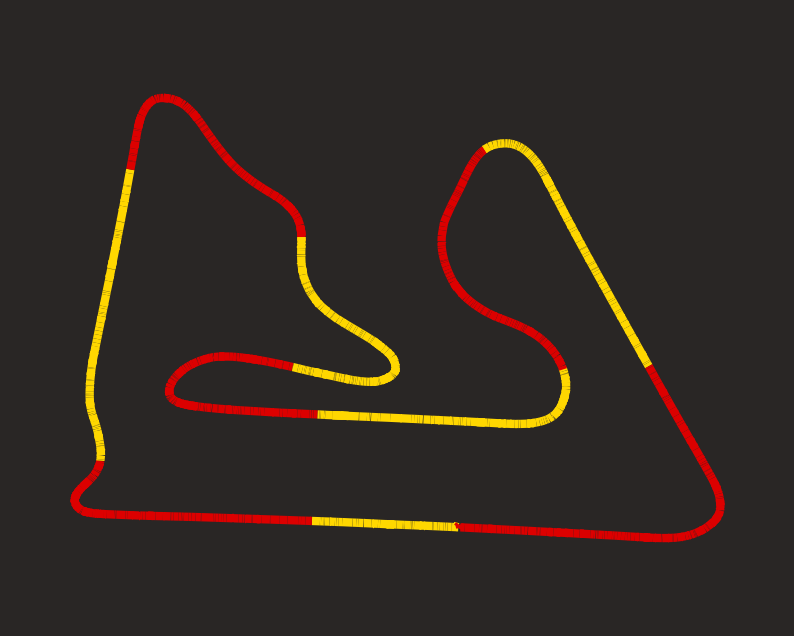

In [ ]:
driver_list = ['LEC', 'SAI']
# Suponiendo que 'session', 'laps', 'driver_list', y 'driver_colors' están previamente definidos

laps = session.laps
laps = laps.pick_quicklaps(threshold=1.03)

telemetry = pd.DataFrame()
for driver in driver_list:
    driver_telemetry = laps.pick_driver(driver).pick_fastest().get_telemetry().add_distance()
    driver_telemetry['Driver'] = driver
    driver_telemetry['Colour'] = driver_colors[driver]
    driver_number = laps.pick_driver(driver).iloc[0]['DriverNumber']
    driver_telemetry['DriverNumber'] = int(driver_number)

    # Intercambia las coordenadas X e Y, y rota la X para mostrar correctamente el circuito
    driver_telemetry_x = driver_telemetry['X']
    driver_telemetry['X'] = driver_telemetry['Y'] * -1
    driver_telemetry['Y'] = driver_telemetry_x

    telemetry = pd.concat([telemetry, driver_telemetry])

telemetry = telemetry[['Distance', 'Speed', 'X', 'Y', 'Driver', 'DriverNumber', 'Colour']]

# Proceso para determinar el piloto más rápido en cada sector

# Define el número de sectores y la longitud de cada sector
num_sectors = 900
total_distance = telemetry['Distance'].max()
sector_length = total_distance / num_sectors

# Assign distances to each sector
sectors = [0]
for i in range(0, (num_sectors - 1)):
    sectors.append(sector_length * (i + 1))

# Assign sector to every row in the telemetry data
telemetry['Sector'] = telemetry['Distance'].apply(
    lambda z: (
        sectors.index(
            min(sectors, key=lambda x: abs(x-z)))+1
    )
)

# Calculate fastest driver (highest average speed) per sector
average_speed = telemetry.groupby(['Sector', 'Driver'])['Speed'].mean().reset_index()

# Select the driver with the highest average speed
fastest_drivers = average_speed.loc[average_speed.groupby(['Sector', 'Driver'])['Speed'].idxmax()]

# Sort to find fastest driver for each sector
fastest_sector = fastest_drivers.sort_values('Speed', ascending=False).drop_duplicates(['Sector'])
fastest_sector = fastest_sector.sort_values(by=['Sector'])
fastest_sector = fastest_sector[['Sector', 'Driver', 'Speed']].rename(columns={'Speed': 'Sector_avg_speed', 'Driver': 'Fastest_driver'})

# Get rid of the speed column and rename the driver column
fastest_drivers = fastest_drivers[['Sector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

# Join the fastest sector dataframe with the full telemetry
# to merge sector, fastest driver in each and avg speed in that sector
telemetry = telemetry.merge(fastest_sector, on=['Sector'])

# Order the data by distance
telemetry = telemetry.sort_values(by=['Distance'])

# Assign integer value to the fastest driver in each sector (driver number)
for driver in driver_list:
    driver_number = telemetry[telemetry['Driver'] == driver].iloc[0]['DriverNumber']
    telemetry.loc[telemetry['Fastest_driver'] == driver, 'Fastest_driver_int'] = driver_number


print(telemetry)
# Configura la figura y ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Obtiene las coordenadas del circuito
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

# Crea una colección de líneas para los segmentos, utilizando los colores de los pilotos más rápidos en cada minisector
segments = []
segment_colors = []

# Define el número de minisectores
num_minisectors = 10
total_distance = telemetry['Distance'].max()
minisector_length = total_distance / num_minisectors

# Assign distances to each minisector
minisectors = [0]
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

# Assign minisector to every row in the telemetry data
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda z: (
        minisectors.index(
            min(minisectors, key=lambda x: abs(x-z)))+1
    )
)

# Calculate fastest driver (highest average speed) per mini sector
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

# Select the driver with the highest average speed
fastest_drivers = average_speed.loc[average_speed.groupby(['Minisector', 'Driver'])['Speed'].idxmax()]

# Assign colors to the fastest drivers in each minisector
minisector_fastest_drivers = fastest_drivers['Driver'].tolist()
minisector_colours = [name_to_color_hex(laps.pick_driver(driver).pick_fastest()['Driver']) for driver in minisector_fastest_drivers]

# Create the segments and assign the colors
for i in range(len(x)-1):
    segments.append([(x[i], y[i]), (x[i+1], y[i+1])])
    segment_colors.append(minisector_colours[telemetry['Minisector'].iloc[i] - 1])

# Crea una colección de líneas para los segmentos usando los colores asignados
lc = LineCollection(segments, colors=segment_colors, linewidths=6)

# Añade la colección de líneas al plot
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.axis('equal')
plt.axis('off')

# Guarda la figura
# Asegúrate de que el directorio exista
dir_path = f"images/generated/directorio_personalizado"
os.makedirs(dir_path, exist_ok=True)
plt.savefig(f"{dir_path}/circuit_sectors.png")

# Muestra el plot
plt.show()


In [62]:


# Suponiendo que 'session', 'driver_list', y 'driver_colors' están previamente definidos
driver_list = ['LEC', 'SAI']

def process_driver_telemetry(session, driver, driver_colors):
    laps = session.laps.pick_quicklaps(threshold=1.03)
    driver_telemetry = laps.pick_driver(driver).pick_fastest().get_telemetry().add_distance()
    driver_telemetry['Driver'] = driver
    driver_telemetry['Colour'] = driver_colors[driver]
    driver_number = laps.pick_driver(driver).iloc[0]['DriverNumber']
    driver_telemetry['DriverNumber'] = int(driver_number)
    driver_telemetry['X'], driver_telemetry['Y'] = -driver_telemetry['Y'], driver_telemetry['X']
    return driver_telemetry

def assign_sectors(telemetry, num_sectors):
    total_distance = telemetry['Distance'].max()
    sector_length = total_distance / num_sectors
    telemetry['Sector'] = telemetry['Distance'] // sector_length + 1
    return telemetry

def calculate_fastest_drivers(telemetry):
    average_speed = telemetry.groupby(['Sector', 'Driver'])['Speed'].mean().reset_index()
    fastest_drivers = average_speed.loc[average_speed.groupby('Sector')['Speed'].idxmax()]
    return fastest_drivers[['Sector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

def plot_circuit(telemetry, driver_list):
    fig, ax = plt.subplots(figsize=(10, 8))
    segments, segment_colors = [], []
    for i in range(len(telemetry) - 1):
        segments.append([(telemetry.iloc[i]['X'], telemetry.iloc[i]['Y']), 
                         (telemetry.iloc[i+1]['X'], telemetry.iloc[i+1]['Y'])])
        segment_colors.append(telemetry.iloc[i]['Colour'])
    lc = LineCollection(segments, colors=segment_colors, linewidths=6)
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.axis('equal')
    plt.axis('off')

    dir_path = f"images/generated/directorio_personalizado"
    os.makedirs(dir_path, exist_ok=True)
    plt.savefig(f"{dir_path}/circuit_sectors.png")

    plt.show()

# Principal
telemetry = pd.concat([process_driver_telemetry(session, driver, driver_colors) for driver in driver_list])
telemetry = assign_sectors(telemetry, 20)
fastest_drivers = calculate_fastest_drivers(telemetry)
telemetry = telemetry.merge(fastest_drivers, on=['Sector'])

for driver in driver_list:
    driver_number = telemetry[telemetry['Driver'] == driver].iloc[0]['DriverNumber']
    telemetry.loc[telemetry['Fastest_driver'] == driver, 'Fastest_driver_int'] = driver_number

telemetry = telemetry.sort_values(by=['Distance'])
plot_circuit(telemetry, driver_list)



NameError: name 'driver_colors' is not defined

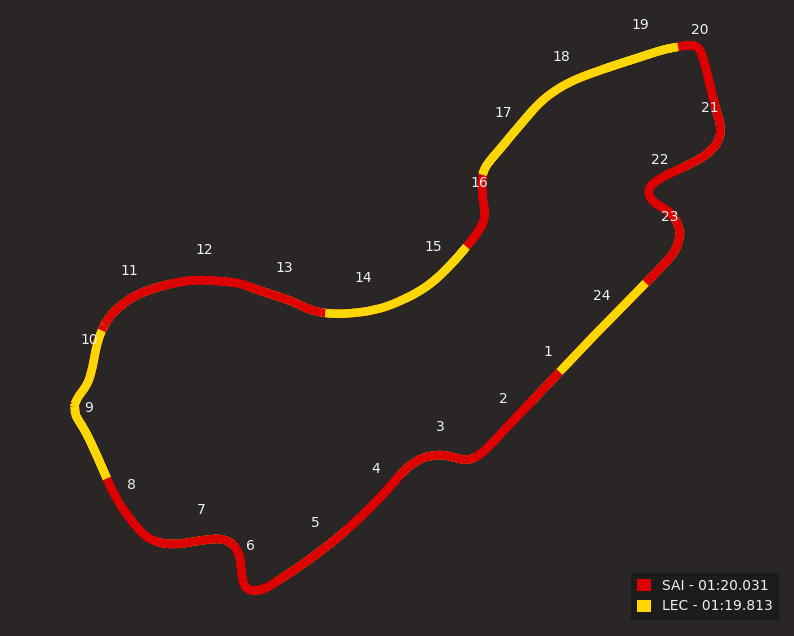

In [189]:
#driver_list = ['VER', 'SAI', 'PER', 'LEC', 'RUS', 'ALO', 'PIA', 'HAM', 'STR']
driver_list = ['SAI','LEC']
# Suponiendo que 'session', 'laps', 'driver_list', y 'driver_colors' están previamente definidos

laps = session.laps
laps = laps.pick_quicklaps(threshold=1.03)

telemetry = pd.DataFrame()
for driver in driver_list:
    driver_telemetry = laps.pick_driver(driver).pick_fastest().get_telemetry().add_distance()
    driver_telemetry['Driver'] = driver
    driver_telemetry['Colour'] = name_to_color_hex(driver)
    driver_number = laps.pick_driver(driver).iloc[0]['DriverNumber']
    driver_telemetry['DriverNumber'] = int(driver_number)

    # Intercambia las coordenadas X e Y, y rota la X para mostrar correctamente el circuito
    driver_telemetry_x = driver_telemetry['X']
    driver_telemetry['X'] = driver_telemetry['Y'] * -1
    driver_telemetry['Y'] = driver_telemetry_x

    telemetry = pd.concat([telemetry, driver_telemetry])


telemetry = telemetry[['Distance', 'Speed', 'X', 'Y', 'Driver', 'DriverNumber', 'Colour', 'Time']]

# Proceso para determinar el piloto más rápido en cada sector

# Configura la figura y ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Obtiene las coordenadas del circuito
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

# Crea una colección de líneas para los segmentos, utilizando los colores de los pilotos más rápidos en cada minisector
segments = []
segment_colors = []
segment_drivers = []

# Define el número de minisectores
num_minisectors = 24
total_distance = telemetry['Distance'].max()
minisector_length = total_distance / num_minisectors

# Assign distances to each minisector
minisectors = [0]
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

# Assign minisector to every row in the telemetry data
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda z: (
        minisectors.index(
            min(minisectors, key=lambda x: abs(x-z)))+1
    )
)

# Calculate fastest driver (highest average speed) per mini sector
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()


# Select the driver with the highest average speed
fastest_drivers = average_speed.loc[average_speed.groupby(['Minisector', 'Driver'])['Speed'].idxmax()]

# Assign colors to the fastest drivers in each minisector
minisector_fastest_drivers = fastest_drivers['Driver'].tolist()

minisector_colours = [name_to_color_hex(laps.pick_driver(driver).pick_fastest()['Driver']) for driver in minisector_fastest_drivers]

datos_para_exportar = pd.DataFrame(telemetry)
ruta_archivo = 'telemtry_sectors.csv'
datos_para_exportar.to_csv(ruta_archivo, index=False)
# Create the segments and assign the colors
minisector_driver_champion = []
for i in range(len(x)-1):
    segments.append([(x[i], y[i]), (x[i+1], y[i+1])])
    segment_colors.append(minisector_colours[telemetry['Minisector'].iloc[i] - 1])
    segment_drivers.append(minisector_fastest_drivers[telemetry['Minisector'].iloc[i] - 1])
    
# Función para convertir la columna 'Time' a segundos
def convert_to_seconds(timedelta_str):
    match = re.match(r'(?P<days>\d+) days (?P<hours>\d{2}):(?P<minutes>\d{2}):(?P<seconds>\d{2}).(?P<microseconds>\d+)', timedelta_str)
    if not match:
        return None
    time_data = match.groupdict()
    time_delta = timedelta(days=int(time_data['days']),
                           hours=int(time_data['hours']),
                           minutes=int(time_data['minutes']),
                           seconds=int(time_data['seconds']),
                           microseconds=int(time_data['microseconds']))
    return time_delta.total_seconds()

driver_for_sector = [] # Inicializa un array vacío
# Muestra la velocidad media del sector
for i in range(1, num_minisectors + 1):

    # Filtra la telemetría por minisector
    minisector_data = telemetry[telemetry['Minisector'] == i]

    datos_para_exportar = pd.DataFrame(minisector_data)
    ruta_archivo = f"minisector_{i}_data.csv"
    datos_para_exportar.to_csv(ruta_archivo, index=False)

    df = pd.DataFrame()
    if not minisector_data.empty:

        # Asumiendo que 'df' es tu DataFrame
        # Convierte la columna 'Time' a segundos
        #df['TimeInSeconds'] = df['Time'].apply(convert_to_seconds)

        # Encuentra el tiempo mínimo y máximo por piloto y minisector
        min_times = datos_para_exportar.groupby(['Driver', 'Minisector'])['Time'].min().reset_index(name='MinTime')
        max_times = datos_para_exportar.groupby(['Driver', 'Minisector'])['Time'].max().reset_index(name='MaxTime')

        # Fusiona los mínimos y máximos en un solo DataFrame
        times = pd.merge(min_times, max_times, on=['Driver', 'Minisector'])

        # Calcula la diferencia de tiempo para cada piloto en cada minisector
        times['TimeDiff'] = times['MaxTime'] - times['MinTime']

        # Ordena y encuentra el piloto más rápido por minisector
        fastest_pilots = times.loc[times.groupby('Minisector')['TimeDiff'].idxmin()]

        # Muestra el resultado

        # Calcula la posición media del minisector
        avg_x = minisector_data['X'].mean()
        avg_y = minisector_data['Y'].mean()
        
        # Obtiene la velocidad promedio para el minisector
        avg_speed = minisector_data['Speed'].mean()
        
        # Velocidad media de sector
        #plt.annotate(f'{avg_speed:.2f} km/h', (avg_x, avg_y), textcoords="offset points", xytext=(0,0), ha='center')

        min_time = minisector_data['Time'].min()
        max_time = minisector_data['Time'].max()
        sector_time = max_time - min_time

        # Tiempo del sector
        #plt.annotate(f'{format_lap_time(sector_time)}', (avg_x, avg_y), textcoords="offset points", xytext=(0,0), ha='center')
        sector_time_fastest = format_lap_time(fastest_pilots['TimeDiff'].iloc[0])
        #plt.annotate(f'{sector_time_fastest}', (avg_x, avg_y), textcoords="offset points", xytext=(0,-10), ha='center')

        # Piloto
        driver_name_fastest = fastest_pilots['Driver'].iloc[0]
        #plt.annotate(f'{driver_name_fastest}', (avg_x, avg_y), textcoords="offset points", xytext=(0,10), ha='center')
        driver_for_sector.append(driver_name_fastest)

        # Número del sector
        plt.annotate(f'{i}', (avg_x, avg_y), textcoords="offset points", xytext=(0,20), ha='center')

for i in range(len(x)-1):
    segments.append([(x[i], y[i]), (x[i+1], y[i+1])])
    segment_colors.append(name_to_color_hex(driver_for_sector[telemetry['Minisector'].iloc[i] - 1]))

# Crea una colección de líneas para los segmentos usando los colores asignados
lc = LineCollection(segments, colors=segment_colors, linewidths=6)

# Añade la colección de líneas al plot
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.axis('equal')
plt.axis('off')
from matplotlib.patches import Patch
# Crear una lista de elementos de leyenda manualmente
#legend_elements = [Patch(facecolor=name_to_color_hex(driver), edgecolor='none', label='VER'),
#                   Patch(facecolor=name_to_color_hex('SAI'), edgecolor='none', label='SAI')]
legend_elements = [Patch(facecolor=name_to_color_hex(driver_list[i]), edgecolor='none', label=f"{driver_list[i]} - {format_lap_time(laps.pick_driver(driver_list[i]).pick_fastest()['LapTime'])}") 
                   for i in range(len(driver_list))]

# Añadir la leyenda con los elementos personalizados
plt.legend(handles=legend_elements, handlelength=1, handleheight=1, loc='lower right')


# Guarda la figura
# Asegúrate de que el directorio exista
dir_path = f"images/generated/{grand_prix_year}/{grand_prix_weekend}/{driver_list[0]}vs{driver_list[1]}"
os.makedirs(dir_path, exist_ok=True)
plt.savefig(f"{dir_path}/circuit_sectors.png")

# Muestra el plot
plt.show()



Ficha completa

['SAI', 'LEC', 'NOR', 'PIA', 'PER', 'ALO', 'RUS', 'STR', 'TSU', 'GAS', 'BOT', 'ZHO', 'HUL', 'MAG', 'OCO', 'ALB', 'RIC']
DriverNumber                                                         55
BroadcastName                                                   C SAINZ
Abbreviation                                                        SAI
DriverId                                                               
TeamName                                                        Ferrari
TeamColor                                                        E80020
TeamId                                                                 
FirstName                                                        Carlos
LastName                                                          Sainz
FullName                                                   Carlos Sainz
HeadshotUrl           https://media.formula1.com/d_driver_fallback_i...
CountryCode                                                         ESP
Position        

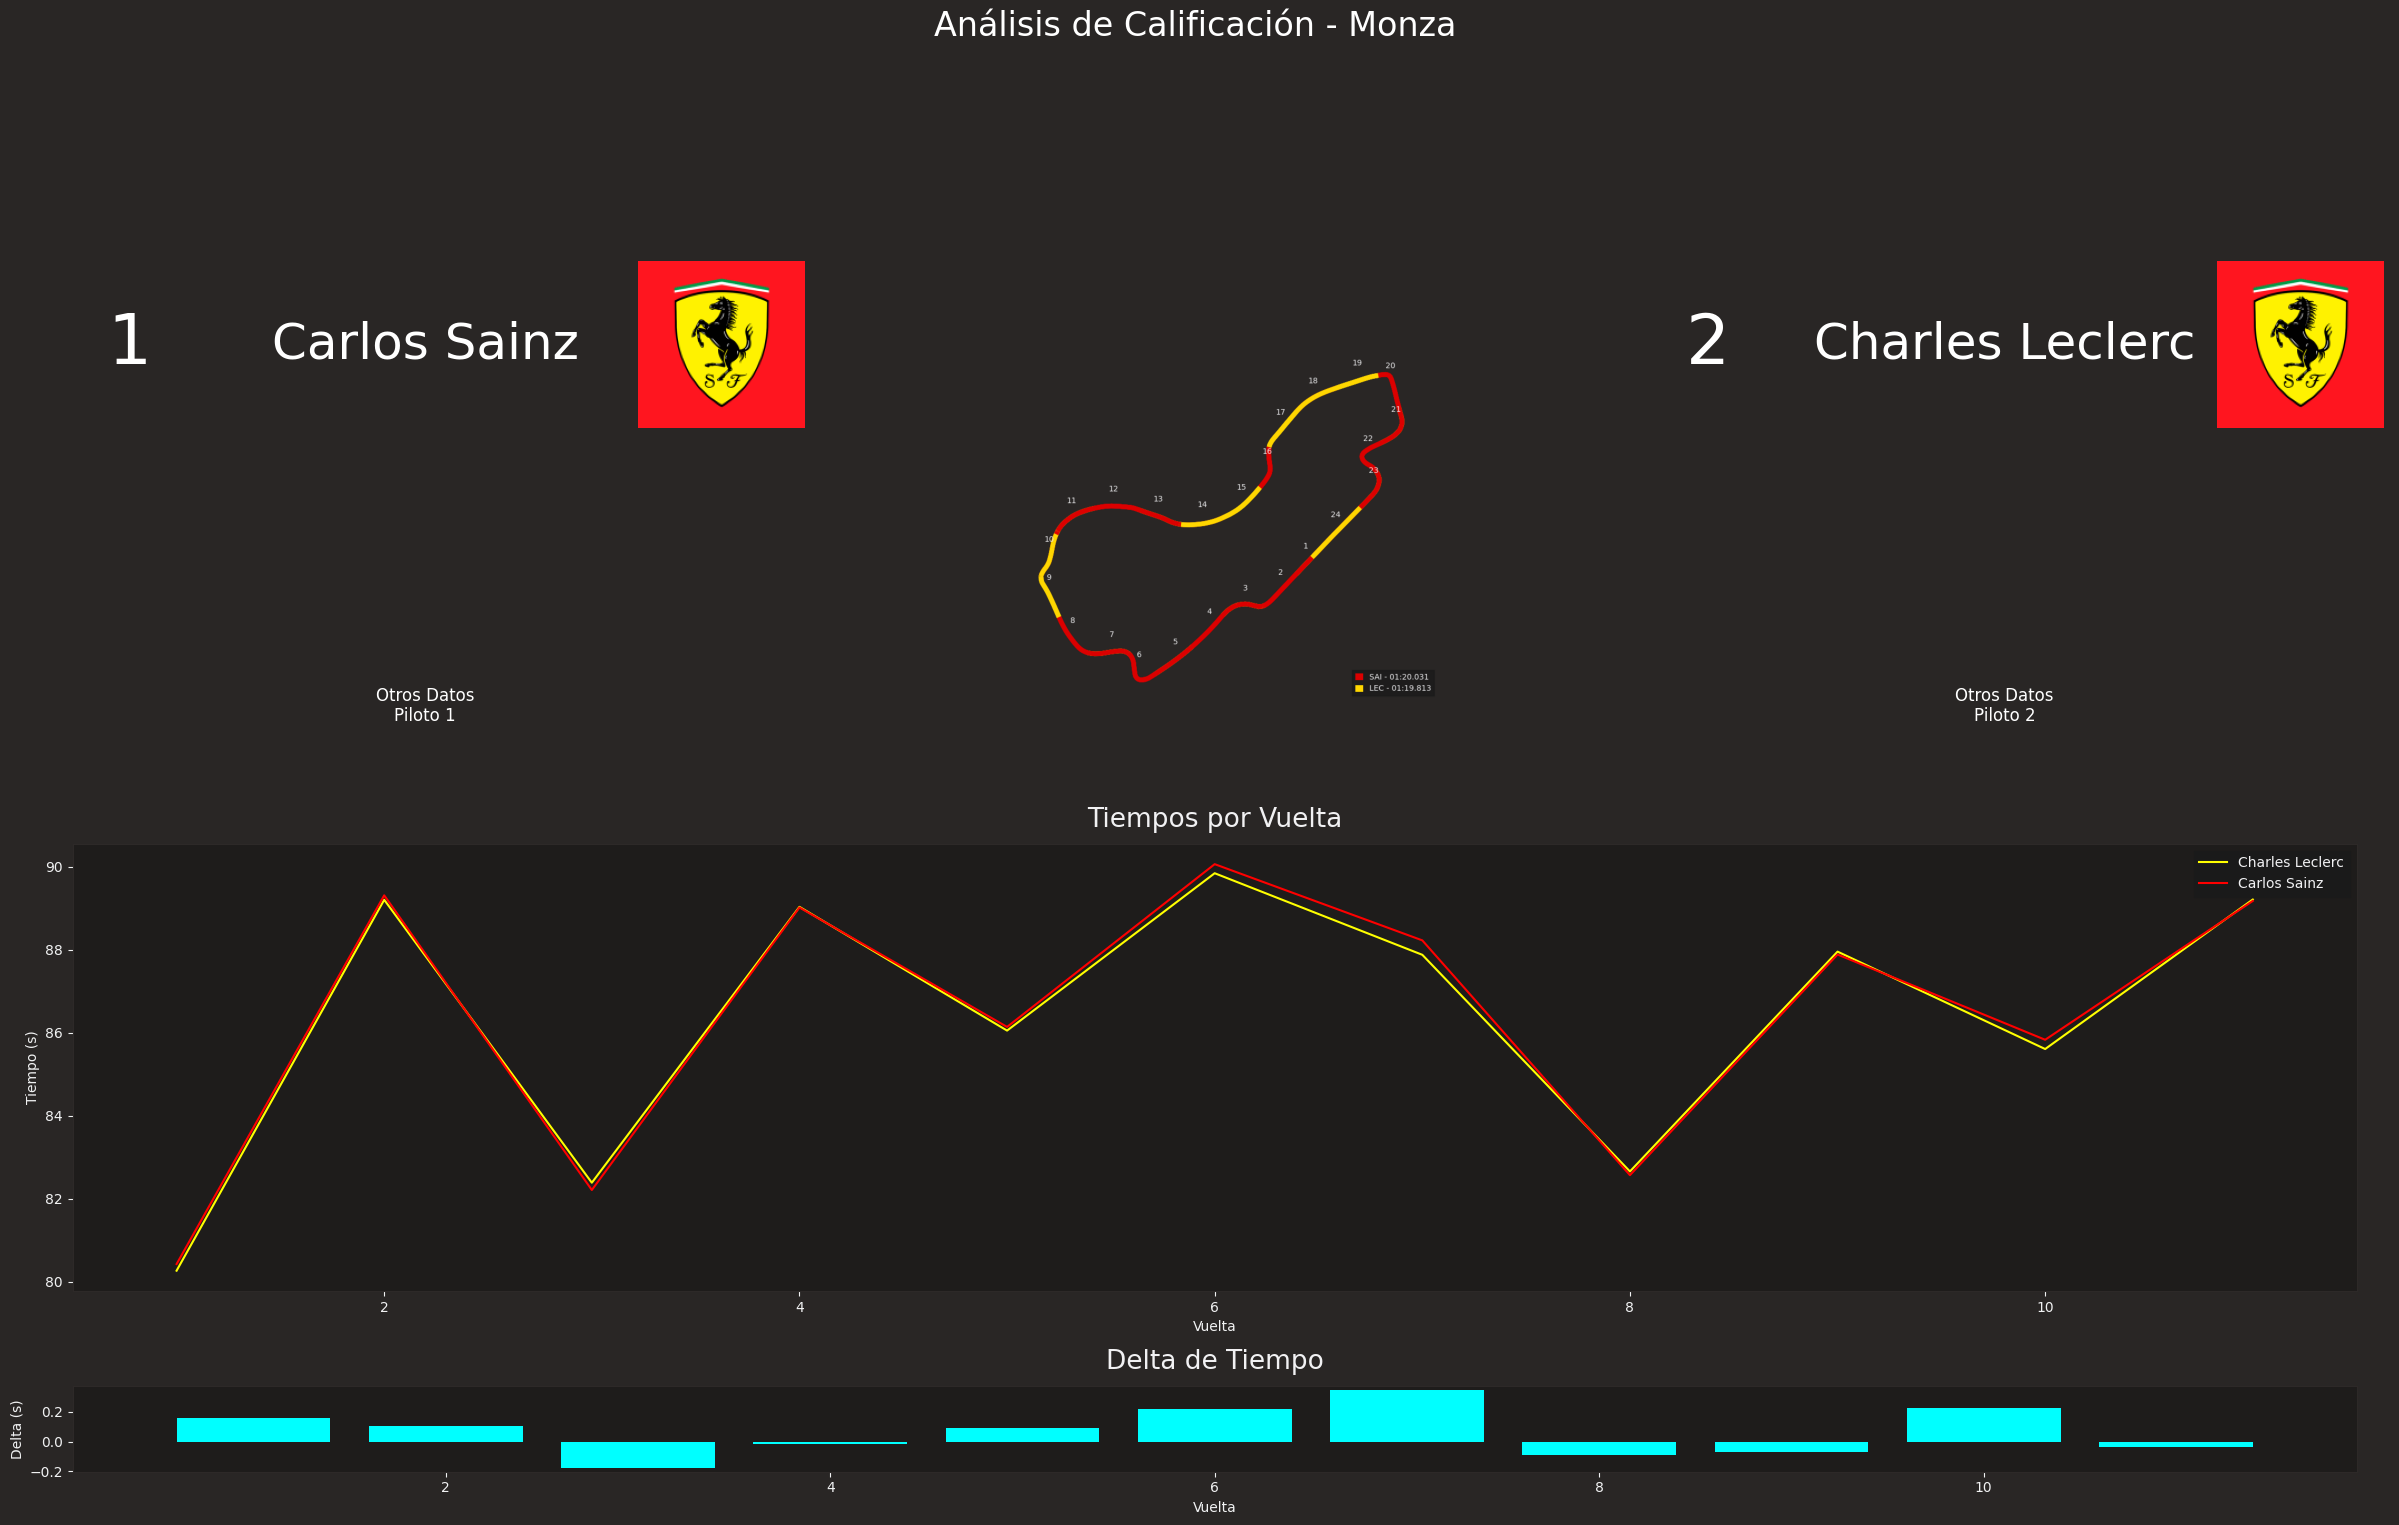

In [190]:
#import numpy as np
#import matplotlib.pyplot as plt
#from matplotlib import gridspec
from matplotlib.image import imread

drivers_to_compare = driver_list
drivers_sorted = drivers_sorted_by_final_time(laps)['Driver'].to_list()
print(drivers_sorted)

driver_1 = session.get_driver(drivers_to_compare[0])
print(driver_1)
driver_2 = session.get_driver(drivers_to_compare[1])

font_driver_number = 50
font_driver_name = 36

# Datos simulados
n_vueltas = 11
vueltas = np.arange(1, n_vueltas + 1)
tiempos_leclerc = np.random.uniform(80, 90, size=n_vueltas)
tiempos_sainz = tiempos_leclerc + np.random.normal(0, 0.2, size=n_vueltas)  # tiempos similares con variación normal
delta_tiempo = tiempos_sainz - tiempos_leclerc

# Iniciar la figura con GridSpec
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(8, 12, figure=fig)

# Título grande del header
fig.suptitle('Análisis de Calificación - Monza', fontsize=24, color='white')

# Información del piloto 1
ax1 = fig.add_subplot(gs[1, 0])
ax1.text(0.5, 0.5, f"{drivers_sorted.index(drivers_to_compare[0]) + 1}", ha='center', va='center', fontsize=font_driver_number, color='white')
ax1.axis('off')

ax2 = fig.add_subplot(gs[1, 1:3])
ax2.text(0.5, 0.5, f"{driver_1['FullName']}", ha='center', va='center', fontsize=font_driver_name, color='white')
ax2.axis('off')

ax3 = fig.add_subplot(gs[1, 3])
#ax3.text(0.5, 0.5, 'Escudo', ha='center', va='center', fontsize=12, color='yellow')
add_team_logo(ax3, f"{driver_1['TeamName']}", zoom=0.8)  # reemplaza 'nombre_equipo' con el nombre correspondiente
ax3.axis('off')

# Información del piloto 2
ax4 = fig.add_subplot(gs[1, 8])
ax4.text(0.5, 0.5, f"{drivers_sorted.index(drivers_to_compare[1]) + 1}", ha='center', va='center', fontsize=font_driver_number, color='white')
ax4.axis('off')

ax5 = fig.add_subplot(gs[1, 9:11])
ax5.text(0.5, 0.5, f"{driver_2['FullName']}", ha='center', va='center', fontsize=font_driver_name, color='white')
ax5.axis('off')

ax6 = fig.add_subplot(gs[1, 11])
#ax6.text(0.5, 0.5, 'Escudo', ha='center', va='center', fontsize=12, color='red')
add_team_logo(ax6, f"{driver_2['TeamName']}", zoom=0.8)  # reemplaza 'nombre_equipo' con el nombre correspondiente
ax6.axis('off')

# Otros datos para los pilotos (simulados por texto por ahora)
ax7 = fig.add_subplot(gs[3, 0:4])
ax7.text(0.5, 0.5, 'Otros Datos\nPiloto 1', ha='center', va='center', fontsize=12, color='white')
ax7.axis('off')

ax8 = fig.add_subplot(gs[3, 8:12])
ax8.text(0.5, 0.5, 'Otros Datos\nPiloto 2', ha='center', va='center', fontsize=12, color='white')
ax8.axis('off')

# Mapa del circuito en el centro
mapa_circuito_imagen = imread(f'images/generated/{grand_prix_year}/{grand_prix_weekend}/{driver_list[0]}vs{driver_list[1]}/circuit_sectors.png')
ax_map = fig.add_subplot(gs[1:4, 4:8])
#ax_map.text(0.5, 0.5, 'Mapa\ndel Circuito', ha='center', va='center', fontsize=12, color='white')
ax_map.imshow(mapa_circuito_imagen)  # Mostramos la imagen precalculada aquí
ax_map.axis('off')


# Tiempos por vuelta de ambos pilotos
ax_time_comparison = fig.add_subplot(gs[4:7, :])
ax_time_comparison.plot(vueltas, tiempos_leclerc, label='Charles Leclerc', color='yellow')
ax_time_comparison.plot(vueltas, tiempos_sainz, label='Carlos Sainz', color='red')
ax_time_comparison.set_title('Tiempos por Vuelta')
ax_time_comparison.set_xlabel('Vuelta')
ax_time_comparison.set_ylabel('Tiempo (s)')
ax_time_comparison.legend()

# Delta de tiempo entre ellos en la fila 8
ax_delta_time = fig.add_subplot(gs[7, :])
ax_delta_time.bar(vueltas, delta_tiempo, color='cyan')
ax_delta_time.set_title('Delta de Tiempo')
ax_delta_time.set_xlabel('Vuelta')
ax_delta_time.set_ylabel('Delta (s)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta el layout para el título
plt.show()
